surfplot only works in earlier version of matplotlib, thus we need to downgrade the matplotlib to `3.4.3`

In [12]:
from neuromaps.datasets import fetch_fslr
import nibabel as nib
from nibabel.freesurfer.io import read_annot
from netneurotools import datasets, freesurfer, stats

from surfplot import Plot
from brainspace.datasets import load_parcellation
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.datasets import load_sc

import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from nilearn import plotting, surface
import matplotlib.pyplot as plt

from statsmodels.stats.multitest import multipletests as fdr
%matplotlib inline

more examples https://surfplot.readthedocs.io/en/latest/

In [1]:
#print(matplotlib.__version__)
#!pip uninstall matplotlib
#!pip install matplotlib==3.4.3

## 1. Prepare the data for comparison
### Load them

In [41]:
# set dirs
base_dir = '/Users/zhangxihan/Library/CloudStorage/Dropbox/From GoogleDrive/Gradient_Shift_Cellular_Basis/Milgram/para/for_Lauren'
cell_dir = base_dir+'/cell_maps'
imaging_dir = base_dir+'/imaging_maps'
figure_dir = base_dir+'/cell_maps_figures'

# csv files
cell_frac = pd.read_csv(cell_dir+'/Jorstad_cell_type_fractions_sample_level.csv',header=0,index_col=0)
sample_info = pd.read_csv(cell_dir+'/sample_info_vertex_reannot_mapped_0.3.csv',header=0,index_col=0)

# update vertex to bihemisphere then merge the tables
# Find indices where 'structure_name' contains 'right' and 'top_level' is 'CTX'
right_ctx_idxs = sample_info.index[
    sample_info["structure_name"].str.contains("right", case=False) &
    (sample_info["top_level"] == "CTX")
]

# Add 32,492 to 'bihemi_vertex' at the selected indices (the original vertex didn't distinguish hemisphere)
sample_info.loc[right_ctx_idxs, "vertex"] += 32492

# merge the MNI coordinates and FSL32K vertex
cell_merged = cell_frac.merge(sample_info[["vertex", "mni_x", "mni_y", "mni_z"]], left_index=True, right_index=True, how="left")
column_order = ["vertex", "mni_x", "mni_y", "mni_z"] + [col for col in cell_frac.columns]
cell_merged = cell_merged[column_order]

# outut the merged table
cell_merged.to_csv(cell_dir+"/Jorstad_cell_type_fractions_with_vertexfsLR32k_MNI.csv", index=True, header=True)

In [4]:
cell_frac

Lamp5      Pax6       Vip      Sncg  Lamp5 Lhx6     L5 ET  \
well_id                                                                   
594        0.000000  0.020851  0.172046  0.000000    0.000000  0.219672   
787        0.000000  0.000000  0.011591  0.052244    0.072564  0.000000   
961        0.022754  0.059858  0.334520  0.020386    0.001047  0.000000   
428        0.036475  0.000000  0.000000  0.000000    0.000000  0.112576   
969        0.058767  0.002543  0.165891  0.000000    0.000000  0.000000   
...             ...       ...       ...       ...         ...       ...   
157772852  0.000000  0.000000  0.220665  0.000000    0.000000  0.068824   
157772980  0.025828  0.000000  0.023024  0.076531    0.023310  0.000000   
157772932  0.000000  0.000000  0.011925  0.114583    0.061498  0.000000   
157773028  0.000000  0.005387  0.000000  0.133191    0.000000  0.000000   
157773012  0.000000  0.017022  0.000000  0.000000    0.088032  0.024013   

            L5/6 NP     L6 CT       L6b     Astro  ...     L4 IT     L6 IT  \
well_id                                            ...                       
594        0.000000  0.006118  0.000000  0.156797  ...  0.000000  0.295942   
787        0.076733  0.000000  0.099090  0.000000  ...  0.000000  0.000000   
961        0.000000  0.010324  0.000000  0.200210  ...  0.000000  0.000000   
428        0.000000  0.221846  0.000000  0.067884  ...  0.427337  0.000907   
969        0.006910  0.000000  0.003359  0.017541  ...  0.202542  0.000000   
...             ...       ...       ...       ...  ...       ...       ...   
157772852  0.000000  0.191011  0.004260  0.149874  ...  0.000000  0.133125   
157772980  0.041639  0.104041  0.064037  0.164599  ...  0.000000  0.150859   
157772932  0.001829  0.000000  0.147873  0.035260  ...  0.000000  0.041893   
157773028  0.000000  0.012628  0.000000  0.000000  ...  0.000000  0.000000   
157773012  0.000000  0.085742  0.000000  0.000000  ...  0.295732  0.000000   

              L5 IT  Chandelier     Pvalb       Sst  Sst Chodl  P-value  \
well_id                                                                   
594        0.000000    0.083237  0.000000  0.000000   0.008712   9999.0   
787        0.472848    0.034791  0.051403  0.021256   0.007115   9999.0   
961        0.000000    0.000000  0.040058  0.176241   0.008920   9999.0   
428        0.000000    0.000000  0.000000  0.000000   0.002911   9999.0   
969        0.000000    0.000000  0.000000  0.017745   0.016641   9999.0   
...             ...         ...       ...       ...        ...      ...   
157772852  0.000000    0.000000  0.018579  0.000000   0.000537   9999.0   
157772980  0.000000    0.011759  0.000000  0.128028   0.011829   9999.0   
157772932  0.046934    0.095146  0.000000  0.105246   0.007620   9999.0   
157773028  0.185784    0.000000  0.000000  0.038038   0.018992   9999.0   
157773012  0.255570    0.000000  0.094903  0.015866   0.011310   9999.0   

           Correlation      RMSE  
well_id                           
594           0.124129  0.997297  
787           0.013697  1.027351  
961           0.119683  1.001560  
428           0.099302  1.005573  
969           0.034819  1.009943  
...                ...       ...  
157772852     0.066399  1.012265  
157772980     0.172979  0.988644  
157772932     0.134321  0.998114  
157773028     0.053725  1.013805  
157773012     0.138165  0.996343  

[1689 rows x 27 columns]

In [5]:
sample_info

structure_id  slab_num slab_type structure_acronym  \
well_id                                                         
594                4077        22        CX            PCLa-i   
2985               4323        11        CX                Cl   
2801               4323        18        CX                Cl   
2273               4440        18        CX               LGd   
2785               4266        17        CX               CA4   
...                 ...       ...       ...               ...   
159439039          4342         7        CX               BLA   
159438991          4785        64        CB               Glo   
159438975          4783        64        CB               Emb   
159438959          4782        64        CB                Dt   
159438943          4782        63        CB                Dt   

                                              structure_name  polygon_id  \
well_id                                                                    
594        paracentral lobule, anterior part, right, infe...       37470   
2985                                        claustrum, right       40517   
2801                                        claustrum, right       41516   
2273                 dorsal lateral geniculate nucleus, left       41473   
2785                                        CA4 field, right       41142   
...                                                      ...         ...   
159439039                          basolateral nucleus, left   147057074   
159438991                              globose nucleus, left   156978055   
159438975                           emboliform nucleus, left   156978968   
159438959                              dentate nucleus, left   156419141   
159438943                              dentate nucleus, left   156513391   

           mri_voxel_x  mri_voxel_y  mri_voxel_z      mni_x  ...      mni_z  \
well_id                                                      ...              
594                 87           52          116   6.281693  ...  46.030920   
2985                66           92           63  29.463218  ...  -6.841868   
2801                66           81          104  30.916352  ...  12.528056   
2273               116           94          101 -24.471659  ...  -2.006094   
2785                63          104          106  33.052748  ... -12.020580   
...                ...          ...          ...        ...  ...        ...   
159439039          112          127           94 -22.782225  ... -17.047163   
159438991           93          139          156  -2.064244  ... -32.234913   
159438975           93          136          153  -1.473180  ... -30.316163   
159438959           93          127          155  -1.313689  ... -24.491054   
159438943          103          139          155 -13.097793  ... -30.168144   

           brain  reg_num  top_level                        region_clean  \
well_id                                                                    
594         9861   4071.0        CTX   paracentral lobule, anterior part   
2985        9861      NaN        NaN                                 NaN   
2801        9861      NaN        NaN                                 NaN   
2273        9861  12922.0       THAL  dorsal lateral geneiculate nucleus   
2785        9861  12895.0       HIPP                           CA4 field   
...          ...      ...        ...                                 ...   
159439039  15697   4341.0       AMYG                 basolateral nucleus   
159438991  15697      NaN        NaN                                 NaN   
159438975  15697      NaN        NaN                                 NaN   
159438959  15697      NaN        NaN                                 NaN   
159438943  15697      NaN        NaN                                 NaN   

              R   A   S  vertex  mm_to_surf  
well_id                                      
594         5.5 -26  44   36902   -1.341842  
2985       26.5  27  

In [6]:
cell_merged

vertex      mni_x      mni_y      mni_z     Lamp5      Pax6  \
well_id                                                                  
594         36902   6.281693 -26.769456  46.030920  0.000000  0.020851   
787         21630 -55.367069 -11.609941 -25.176097  0.000000  0.000000   
961         11031 -33.515487  25.699183  -0.886969  0.022754  0.059858   
428         37850  17.957951 -29.893537  63.280191  0.036475  0.000000   
969         22313 -50.810163 -53.746933 -18.514183  0.058767  0.002543   
...           ...        ...        ...        ...       ...       ...   
157772852   29249  -3.752821  43.476613  50.869819  0.000000  0.000000   
157772980   28126  -2.587349  38.103551  -7.806132  0.025828  0.000000   
157772932   21168  -7.015003  37.579293 -23.541547  0.000000  0.000000   
157773028   11603 -49.525825  39.373684 -10.073415  0.000000  0.005387   
157773012   11596 -52.317688  39.207707   5.847545  0.000000  0.017022   

                Vip      Sncg  Lamp5 Lhx6     L5 ET  ...     L4 IT     L6 IT  \
well_id                                              ...                       
594        0.172046  0.000000    0.000000  0.219672  ...  0.000000  0.295942   
787        0.011591  0.052244    0.072564  0.000000  ...  0.000000  0.000000   
961        0.334520  0.020386    0.001047  0.000000  ...  0.000000  0.000000   
428        0.000000  0.000000    0.000000  0.112576  ...  0.427337  0.000907   
969        0.165891  0.000000    0.000000  0.000000  ...  0.202542  0.000000   
...             ...       ...         ...       ...  ...       ...       ...   
157772852  0.220665  0.000000    0.000000  0.068824  ...  0.000000  0.133125   
157772980  0.023024  0.076531    0.023310  0.000000  ...  0.000000  0.150859   
157772932  0.011925  0.114583    0.061498  0.000000  ...  0.000000  0.041893   
157773028  0.000000  0.133191    0.000000  0.000000  ...  0.000000  0.000000   
157773012  0.000000  0.000000    0.088032  0.024013  ...  0.295732  0.000000   

              L5 IT  Chandelier     Pvalb       Sst  Sst Chodl  P-value  \
well_id                                                                   
594        0.000000    0.083237  0.000000  0.000000   0.008712   9999.0   
787        0.472848    0.034791  0.051403  0.021256   0.007115   9999.0   
961        0.000000    0.000000  0.040058  0.176241   0.008920   9999.0   
428        0.000000    0.000000  0.000000  0.000000   0.002911   9999.0   
969        0.000000    0.000000  0.000000  0.017745   0.016641   9999.0   
...             ...         ...       ...       ...        ...      ...   
157772852  0.000000    0.000000  0.018579  0.000000   0.000537   9999.0   
157772980  0.000000    0.011759  0.000000  0.128028   0.011829   9999.0   
157772932  0.046934    0.095146  0.000000  0.105246   0.007620   9999.0   
157773028  0.185784    0.000000  0.000000  0.038038   0.018992   9999.0   
157773012  0.255570    0.000000  0.094903  0.015866   0.011310   9999.0   

           Correlation      RMSE  
well_id                           
594           0.124129  0.997297  
787           0.013697  1.027351  
961           0.119683  1.001560  
428           0.099302  1.005573  
969           0.034819  1.009943  
...                ...       ...  
157772852     0.066399  1.012265  
157772980     0.172979  0.988644  
157772932     0.134321  0.998114  
157773028     0.053725  1.013805  
157773012     0.138165  0.996343  

[1689 rows x 31 columns]

### Map the fsLR32k vertex to DK atlas

In [7]:
# use the DK atlas provided by enigmatoolbox 'aparc_conte69.csv'
DK_path = '/Users/zhangxihan/opt/anaconda3/lib/python3.8/site-packages/enigmatoolbox-1.1.3-py3.8.egg/enigmatoolbox/datasets/parcellations/aparc_conte69.csv'
fsLR32k_to_DK = pd.read_csv(DK_path,header=None,index_col=None).values.flatten()

df = cell_merged.copy()
# Map vertices to their corresponding DK parcel
df['DK_parcel'] = df['vertex'].map(lambda v: fsLR32k_to_DK[v])

# Drop the redundant columns
df = df.drop(columns=['vertex','mni_x','mni_y','mni_z','P-value','Correlation','RMSE'])

# Compute the mean cell fractions per DK parcel
df_grouped = df.groupby('DK_parcel').mean()
df_grouped = df_grouped.reset_index()
df_grouped

DK_parcel     Lamp5      Pax6       Vip      Sncg  Lamp5 Lhx6     L5 ET  \
0           0  0.002281  0.032548  0.024554  0.036628    0.013239  0.140031   
1           1  0.023902  0.021467  0.007805  0.024911    0.024609  0.041815   
2           2  0.011892  0.055149  0.070172  0.026345    0.009949  0.108687   
3           3  0.032014  0.032996  0.133127  0.013235    0.016942  0.124581   
4           4  0.025307  0.039920  0.150252  0.030980    0.007846  0.089517   
..        ...       ...       ...       ...       ...         ...       ...   
65         66  0.029541  0.027495  0.068604  0.029376    0.015737  0.036799   
66         67  0.035012  0.019182  0.057574  0.057111    0.011594  0.000000   
67         68  0.000000  0.037593  0.108957  0.059700    0.004276  0.044820   
68         69  0.072168  0.000000  0.096630  0.000000    0.000000  0.077051   
69         70  0.010921  0.016336  0.129630  0.047749    0.049621  0.013219   

     L5/6 NP     L6 CT       L6b  ...       OPC   L2/3 IT  L6 IT Car3  \
0   0.062711  0.146236  0.030299  ...  0.054774  0.016715    0.038770   
1   0.037344  0.006427  0.048711  ...  0.116494  0.226260    0.005821   
2   0.020615  0.137762  0.014457  ...  0.048938  0.000000    0.022912   
3   0.017319  0.037022  0.024654  ...  0.074246  0.082395    0.012538   
4   0.022057  0.106735  0.015395  ...  0.047520  0.026409    0.011998   
..       ...       ...       ...  ...       ...       ...         ...   
65  0.031810  0.015765  0.019483  ...  0.066139  0.269225    0.000000   
66  0.030131  0.053144  0.095494  ...  0.000000  0.283553    0.029870   
67  0.037546  0.033764  0.036644  ...  0.040708  0.042962    0.071637   
68  0.003312  0.064873  0.011609  ...  0.099198  0.073990    0.006370   
69  0.032535  0.081080  0.091664  ...  0.012196  0.066732    0.075364   

       L4 IT     L6 IT     L5 IT  Chandelier     Pvalb       Sst  Sst Chodl  
0   0.000000  0.022179  0.041419    0.028221  0.000000  0.049787   0.021739  
1   0.072284  0.087165  0.121154    0.019281  0.036262  0.023171   0.006323  
2   0.000000  0.140218  0.017559    0.045883  0.001803  0.034540   0.020937  
3   0.053489  0.114403  0.099151    0.014735  0.041725  0.007334   0.006372  
4   0.090519  0.021712  0.027765    0.045531  0.045630  0.026305   0.011557  
..       ...       ...       ...         ...       ...       ...        ...  
65  0.056483  0.078565  0.088327    0.026407  0.030763  0.036637   0.006390  
66  0.000000  0.016811  0.093749    0.031557  0.002733  0.088127   0.005902  
67  0.000000  0.247929  0.000000    0.055432  0.000000  0.028944   0.010877  
68  0.414749  0.000000  0.014154    0.000000  0.044538  0.000000   0.000000  
69  0.055667  0.081193  0.000000    0.037639  0.000308  0.047365   0.014254  

[70 rows x 25 columns]

### Check the total parcel numbr of DK atlas provided by enigmatoolbox and corresponding label
'aparc_conte69.csv' has 71 values, but enigmatoolbox didn't provide the corresponding label for these 71 number-what they have is 68 parcel version. (/Users/zhangxihan/opt/anaconda3/lib/python3.8/site-packages/enigmatoolbox-1.1.3-py3.8.egg/enigmatoolbox/datasets/matrices/hcp_connectivity/strucLabels_ctx.csv)

I ended up guessing the parcel label by cross-referring the freesurfer labels of 'aparc', which has 36 labels per hemisphere. After comparing the two, I found additional labels are "unknown" and "corpuscallosum". 

I think "unknown" is likely to be "0" that didn't tell differencen between left and right hemispheres, so there's 35 labels per hemisphere. The "corpuscallosum" is the 4th label within each freesurfer hemisphere after removing "unknown". The parcel that didn't have cell fractions values loaded was the "39", which happen to be the "corpuscallosum" in the right hemisphere. Taken together, I think It's reasonable to belive "0", "4", and "39" are ok to take out when comparing the cell fractions with traditional DK atlas with 68 parcels.

In [8]:
np.unique(fsLR32k_to_DK)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70])

In [9]:
df_grouped['DK_parcel'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70])

In [10]:
# labels for the DK parcellation, stored in
strucMatrix_ctx, strucLabels_ctx, strucMatrix_sctx, strucLabels_sctx = load_sc(parcellation='aparc')
# strucLabels_ctx contains the cortical labels
# strucLabels_sctx contains the subcortical labels

print("Cortical Labels:")
print(strucLabels_ctx)
print(len(strucLabels_ctx))

Cortical Labels:
['L_bankssts' 'L_caudalanteriorcingulate' 'L_caudalmiddlefrontal'
 'L_cuneus' 'L_entorhinal' 'L_fusiform' 'L_inferiorparietal'
 'L_inferiortemporal' 'L_isthmuscingulate' 'L_lateraloccipital'
 'L_lateralorbitofrontal' 'L_lingual' 'L_medialorbitofrontal'
 'L_middletemporal' 'L_parahippocampal' 'L_paracentral'
 'L_parsopercularis' 'L_parsorbitalis' 'L_parstriangularis'
 'L_pericalcarine' 'L_postcentral' 'L_posteriorcingulate' 'L_precentral'
 'L_precuneus' 'L_rostralanteriorcingulate' 'L_rostralmiddlefrontal'
 'L_superiorfrontal' 'L_superiorparietal' 'L_superiortemporal'
 'L_supramarginal' 'L_frontalpole' 'L_temporalpole' 'L_transversetemporal'
 'L_insula' 'R_bankssts' 'R_caudalanteriorcingulate'
 'R_caudalmiddlefrontal' 'R_cuneus' 'R_entorhinal' 'R_fusiform'
 'R_inferiorparietal' 'R_inferiortemporal' 'R_isthmuscingulate'
 'R_lateraloccipital' 'R_lateralorbitofrontal' 'R_lingual'
 'R_medialorbitofrontal' 'R_middletemporal' 'R_parahippocampal'
 'R_paracentral' 'R_parsopercu

In [13]:
lh_annot_path = "/Applications/freesurfer/7.2.0/subjects/fsaverage6/label/lh.aparc.annot"
rh_annot_path = "/Applications/freesurfer/7.2.0/subjects/fsaverage6/label/rh.aparc.annot"
lh_labels, lh_ctab, lh_names = read_annot(lh_annot_path)  # Left hemisphere
rh_labels, rh_ctab, rh_names = read_annot(rh_annot_path)  # Right hemisphere

# Convert byte labels to readable strings
lh_region_names = [name.decode("utf-8") for name in lh_names]
rh_region_names = [name.decode("utf-8") for name in rh_names]

lh_region_names

['unknown',
 'bankssts',
 'caudalanteriorcingulate',
 'caudalmiddlefrontal',
 'corpuscallosum',
 'cuneus',
 'entorhinal',
 'fusiform',
 'inferiorparietal',
 'inferiortemporal',
 'isthmuscingulate',
 'lateraloccipital',
 'lateralorbitofrontal',
 'lingual',
 'medialorbitofrontal',
 'middletemporal',
 'parahippocampal',
 'paracentral',
 'parsopercularis',
 'parsorbitalis',
 'parstriangularis',
 'pericalcarine',
 'postcentral',
 'posteriorcingulate',
 'precentral',
 'precuneus',
 'rostralanteriorcingulate',
 'rostralmiddlefrontal',
 'superiorfrontal',
 'superiorparietal',
 'superiortemporal',
 'supramarginal',
 'frontalpole',
 'temporalpole',
 'transversetemporal',
 'insula']

#### 1. Map for visualization
This map should be consistent with 0-70 index of 'aparc_conte69' from enigmatoolbox.

In [14]:
# This is for visualization
# Add new row with index 39
new_row = pd.DataFrame([[39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns=df_grouped.columns)
df_vis = pd.concat([df_grouped.iloc[:39], new_row, df_grouped.iloc[39:]]).reset_index(drop=True)
df_vis = df_vis.drop(['DK_parcel'],axis=1)

In [15]:
df_vis

Lamp5      Pax6       Vip      Sncg  Lamp5 Lhx6     L5 ET   L5/6 NP  \
0   0.002281  0.032548  0.024554  0.036628    0.013239  0.140031  0.062711   
1   0.023902  0.021467  0.007805  0.024911    0.024609  0.041815  0.037344   
2   0.011892  0.055149  0.070172  0.026345    0.009949  0.108687  0.020615   
3   0.032014  0.032996  0.133127  0.013235    0.016942  0.124581  0.017319   
4   0.025307  0.039920  0.150252  0.030980    0.007846  0.089517  0.022057   
..       ...       ...       ...       ...         ...       ...       ...   
66  0.029541  0.027495  0.068604  0.029376    0.015737  0.036799  0.031810   
67  0.035012  0.019182  0.057574  0.057111    0.011594  0.000000  0.030131   
68  0.000000  0.037593  0.108957  0.059700    0.004276  0.044820  0.037546   
69  0.072168  0.000000  0.096630  0.000000    0.000000  0.077051  0.003312   
70  0.010921  0.016336  0.129630  0.047749    0.049621  0.013219  0.032535   

       L6 CT       L6b     Astro  ...       OPC   L2/3 IT  L6 IT Car3  \
0   0.146236  0.030299  0.114543  ...  0.054774  0.016715    0.038770   
1   0.006427  0.048711  0.014679  ...  0.116494  0.226260    0.005821   
2   0.137762  0.014457  0.120463  ...  0.048938  0.000000    0.022912   
3   0.037022  0.024654  0.021204  ...  0.074246  0.082395    0.012538   
4   0.106735  0.015395  0.084532  ...  0.047520  0.026409    0.011998   
..       ...       ...       ...  ...       ...       ...         ...   
66  0.015765  0.019483  0.014977  ...  0.066139  0.269225    0.000000   
67  0.053144  0.095494  0.046433  ...  0.000000  0.283553    0.029870   
68  0.033764  0.036644  0.049237  ...  0.040708  0.042962    0.071637   
69  0.064873  0.011609  0.010728  ...  0.099198  0.073990    0.006370   
70  0.081080  0.091664  0.047393  ...  0.012196  0.066732    0.075364   

       L4 IT     L6 IT     L5 IT  Chandelier     Pvalb       Sst  Sst Chodl  
0   0.000000  0.022179  0.041419    0.028221  0.000000  0.049787   0.021739  
1   0.072284  0.087165  0.121154    0.019281  0.036262  0.023171   0.006323  
2   0.000000  0.140218  0.017559    0.045883  0.001803  0.034540   0.020937  
3   0.053489  0.114403  0.099151    0.014735  0.041725  0.007334   0.006372  
4   0.090519  0.021712  0.027765    0.045531  0.045630  0.026305   0.011557  
..       ...       ...       ...         ...       ...       ...        ...  
66  0.056483  0.078565  0.088327    0.026407  0.030763  0.036637   0.006390  
67  0.000000  0.016811  0.093749    0.031557  0.002733  0.088127   0.005902  
68  0.000000  0.247929  0.000000    0.055432  0.000000  0.028944   0.010877  
69  0.414749  0.000000  0.014154    0.000000  0.044538  0.000000   0.000000  
70  0.055667  0.081193  0.000000    0.037639  0.000308  0.047365   0.014254  

[71 rows x 24 columns]

In [16]:
# Output the table
# creat label column
Dk_label = []
Dk_label.append(lh_region_names[0])
for label in lh_region_names[1:]: 
    Dk_label.append('L_'+label)
for label in lh_region_names[1:]: 
    Dk_label.append('R_'+label)
# insert the label column then output
df_vis_out = df_vis.copy()
df_vis_out.insert(0, 'Dk_label', Dk_label)
df_vis_out.to_csv(cell_dir+'/DK_Jorstad_NormZscore0.3.csv',header=True,index=False)
df_vis_out

Dk_label     Lamp5      Pax6       Vip      Sncg  \
0                     unknown  0.002281  0.032548  0.024554  0.036628   
1                  L_bankssts  0.023902  0.021467  0.007805  0.024911   
2   L_caudalanteriorcingulate  0.011892  0.055149  0.070172  0.026345   
3       L_caudalmiddlefrontal  0.032014  0.032996  0.133127  0.013235   
4            L_corpuscallosum  0.025307  0.039920  0.150252  0.030980   
..                        ...       ...       ...       ...       ...   
66            R_supramarginal  0.029541  0.027495  0.068604  0.029376   
67              R_frontalpole  0.035012  0.019182  0.057574  0.057111   
68             R_temporalpole  0.000000  0.037593  0.108957  0.059700   
69       R_transversetemporal  0.072168  0.000000  0.096630  0.000000   
70                   R_insula  0.010921  0.016336  0.129630  0.047749   

    Lamp5 Lhx6     L5 ET   L5/6 NP     L6 CT       L6b  ...       OPC  \
0     0.013239  0.140031  0.062711  0.146236  0.030299  ...  0.054774   
1     0.024609  0.041815  0.037344  0.006427  0.048711  ...  0.116494   
2     0.009949  0.108687  0.020615  0.137762  0.014457  ...  0.048938   
3     0.016942  0.124581  0.017319  0.037022  0.024654  ...  0.074246   
4     0.007846  0.089517  0.022057  0.106735  0.015395  ...  0.047520   
..         ...       ...       ...       ...       ...  ...       ...   
66    0.015737  0.036799  0.031810  0.015765  0.019483  ...  0.066139   
67    0.011594  0.000000  0.030131  0.053144  0.095494  ...  0.000000   
68    0.004276  0.044820  0.037546  0.033764  0.036644  ...  0.040708   
69    0.000000  0.077051  0.003312  0.064873  0.011609  ...  0.099198   
70    0.049621  0.013219  0.032535  0.081080  0.091664  ...  0.012196   

     L2/3 IT  L6 IT Car3     L4 IT     L6 IT     L5 IT  Chandelier     Pvalb  \
0   0.016715    0.038770  0.000000  0.022179  0.041419    0.028221  0.000000   
1   0.226260    0.005821  0.072284  0.087165  0.121154    0.019281  0.036262   
2   0.000000    0.022912  0.000000  0.140218  0.017559    0.045883  0.001803   
3   0.082395    0.012538  0.053489  0.114403  0.099151    0.014735  0.041725   
4   0.026409    0.011998  0.090519  0.021712  0.027765    0.045531  0.045630   
..       ...         ...       ...       ...       ...         ...       ...   
66  0.269225    0.000000  0.056483  0.078565  0.088327    0.026407  0.030763   
67  0.283553    0.029870  0.000000  0.016811  0.093749    0.031557  0.002733   
68  0.042962    0.071637  0.000000  0.247929  0.000000    0.055432  0.000000   
69  0.073990    0.006370  0.414749  0.000000  0.014154    0.000000  0.044538   
70  0.066732    0.075364  0.055667  0.081193  0.000000    0.037639  0.000308   

         Sst  Sst Chodl  
0   0.049787   0.021739  
1   0.023171   0.006323  
2   0.034540   0.020937  
3   0.007334   0.006372  
4   0.026305   0.011557  
..       ...        ...  
66  0.036637   0.006390  
67  0.088127   0.005902  
68  0.028944   0.010877  
69  0.000000   0.000000  
70  0.047365   0.014254  

[71 rows x 25 columns]

#### 2. Map for correlation
This map should kick out "unknown" (0) and "corpuscallosum" (4, 39). Here we only need to drop 0 and 4 since 39 is missing already.

In [17]:
df_cor = df_grouped.drop(index=[0,4],columns=['DK_parcel'])
df_cor

Lamp5      Pax6       Vip      Sncg  Lamp5 Lhx6     L5 ET   L5/6 NP  \
1   0.023902  0.021467  0.007805  0.024911    0.024609  0.041815  0.037344   
2   0.011892  0.055149  0.070172  0.026345    0.009949  0.108687  0.020615   
3   0.032014  0.032996  0.133127  0.013235    0.016942  0.124581  0.017319   
5   0.046654  0.009114  0.021738  0.000000    0.016948  0.035381  0.017265   
6   0.009750  0.013038  0.050692  0.063094    0.013573  0.019965  0.000000   
..       ...       ...       ...       ...         ...       ...       ...   
65  0.029541  0.027495  0.068604  0.029376    0.015737  0.036799  0.031810   
66  0.035012  0.019182  0.057574  0.057111    0.011594  0.000000  0.030131   
67  0.000000  0.037593  0.108957  0.059700    0.004276  0.044820  0.037546   
68  0.072168  0.000000  0.096630  0.000000    0.000000  0.077051  0.003312   
69  0.010921  0.016336  0.129630  0.047749    0.049621  0.013219  0.032535   

       L6 CT       L6b     Astro  ...       OPC   L2/3 IT  L6 IT Car3  \
1   0.006427  0.048711  0.014679  ...  0.116494  0.226260    0.005821   
2   0.137762  0.014457  0.120463  ...  0.048938  0.000000    0.022912   
3   0.037022  0.024654  0.021204  ...  0.074246  0.082395    0.012538   
5   0.047552  0.002865  0.005761  ...  0.068016  0.075593    0.007504   
6   0.067606  0.000000  0.376955  ...  0.000000  0.018288    0.052361   
..       ...       ...       ...  ...       ...       ...         ...   
65  0.015765  0.019483  0.014977  ...  0.066139  0.269225    0.000000   
66  0.053144  0.095494  0.046433  ...  0.000000  0.283553    0.029870   
67  0.033764  0.036644  0.049237  ...  0.040708  0.042962    0.071637   
68  0.064873  0.011609  0.010728  ...  0.099198  0.073990    0.006370   
69  0.081080  0.091664  0.047393  ...  0.012196  0.066732    0.075364   

       L4 IT     L6 IT     L5 IT  Chandelier     Pvalb       Sst  Sst Chodl  
1   0.072284  0.087165  0.121154    0.019281  0.036262  0.023171   0.006323  
2   0.000000  0.140218  0.017559    0.045883  0.001803  0.034540   0.020937  
3   0.053489  0.114403  0.099151    0.014735  0.041725  0.007334   0.006372  
5   0.453010  0.047956  0.030559    0.009201  0.060221  0.015783   0.001447  
6   0.000000  0.028626  0.026052    0.047236  0.000000  0.061686   0.005822  
..       ...       ...       ...         ...       ...       ...        ...  
65  0.056483  0.078565  0.088327    0.026407  0.030763  0.036637   0.006390  
66  0.000000  0.016811  0.093749    0.031557  0.002733  0.088127   0.005902  
67  0.000000  0.247929  0.000000    0.055432  0.000000  0.028944   0.010877  
68  0.414749  0.000000  0.014154    0.000000  0.044538  0.000000   0.000000  
69  0.055667  0.081193  0.000000    0.037639  0.000308  0.047365   0.014254  

[68 rows x 24 columns]

In [18]:
# Output the table
# creat label column
Dk_label = []
for label in lh_region_names[1:4]: 
    Dk_label.append('L_'+label)
for label in lh_region_names[5:]: 
    Dk_label.append('L_'+label)
for label in lh_region_names[1:4]: 
    Dk_label.append('R_'+label)
for label in lh_region_names[5:]: 
    Dk_label.append('R_'+label)
# insert the label column then output
df_cor_out = df_cor.copy()
df_cor_out.insert(0, 'Dk_label', Dk_label)
df_cor_out.to_csv(cell_dir+'/DK68_Jorstad_NormZscore0.3.csv',header=True,index=False)
df_cor_out

Dk_label     Lamp5      Pax6       Vip      Sncg  \
1                  L_bankssts  0.023902  0.021467  0.007805  0.024911   
2   L_caudalanteriorcingulate  0.011892  0.055149  0.070172  0.026345   
3       L_caudalmiddlefrontal  0.032014  0.032996  0.133127  0.013235   
5                    L_cuneus  0.046654  0.009114  0.021738  0.000000   
6                L_entorhinal  0.009750  0.013038  0.050692  0.063094   
..                        ...       ...       ...       ...       ...   
65            R_supramarginal  0.029541  0.027495  0.068604  0.029376   
66              R_frontalpole  0.035012  0.019182  0.057574  0.057111   
67             R_temporalpole  0.000000  0.037593  0.108957  0.059700   
68       R_transversetemporal  0.072168  0.000000  0.096630  0.000000   
69                   R_insula  0.010921  0.016336  0.129630  0.047749   

    Lamp5 Lhx6     L5 ET   L5/6 NP     L6 CT       L6b  ...       OPC  \
1     0.024609  0.041815  0.037344  0.006427  0.048711  ...  0.116494   
2     0.009949  0.108687  0.020615  0.137762  0.014457  ...  0.048938   
3     0.016942  0.124581  0.017319  0.037022  0.024654  ...  0.074246   
5     0.016948  0.035381  0.017265  0.047552  0.002865  ...  0.068016   
6     0.013573  0.019965  0.000000  0.067606  0.000000  ...  0.000000   
..         ...       ...       ...       ...       ...  ...       ...   
65    0.015737  0.036799  0.031810  0.015765  0.019483  ...  0.066139   
66    0.011594  0.000000  0.030131  0.053144  0.095494  ...  0.000000   
67    0.004276  0.044820  0.037546  0.033764  0.036644  ...  0.040708   
68    0.000000  0.077051  0.003312  0.064873  0.011609  ...  0.099198   
69    0.049621  0.013219  0.032535  0.081080  0.091664  ...  0.012196   

     L2/3 IT  L6 IT Car3     L4 IT     L6 IT     L5 IT  Chandelier     Pvalb  \
1   0.226260    0.005821  0.072284  0.087165  0.121154    0.019281  0.036262   
2   0.000000    0.022912  0.000000  0.140218  0.017559    0.045883  0.001803   
3   0.082395    0.012538  0.053489  0.114403  0.099151    0.014735  0.041725   
5   0.075593    0.007504  0.453010  0.047956  0.030559    0.009201  0.060221   
6   0.018288    0.052361  0.000000  0.028626  0.026052    0.047236  0.000000   
..       ...         ...       ...       ...       ...         ...       ...   
65  0.269225    0.000000  0.056483  0.078565  0.088327    0.026407  0.030763   
66  0.283553    0.029870  0.000000  0.016811  0.093749    0.031557  0.002733   
67  0.042962    0.071637  0.000000  0.247929  0.000000    0.055432  0.000000   
68  0.073990    0.006370  0.414749  0.000000  0.014154    0.000000  0.044538   
69  0.066732    0.075364  0.055667  0.081193  0.000000    0.037639  0.000308   

         Sst  Sst Chodl  
1   0.023171   0.006323  
2   0.034540   0.020937  
3   0.007334   0.006372  
5   0.015783   0.001447  
6   0.061686   0.005822  
..       ...        ...  
65  0.036637   0.006390  
66  0.088127   0.005902  
67  0.028944   0.010877  
68  0.000000   0.000000  
69  0.047365   0.014254  

[68 rows x 25 columns]

## 2. Visualizing the cell map in DK atlas

In [19]:
list(df_vis.keys())

['Lamp5',
 'Pax6',
 'Vip',
 'Sncg',
 'Lamp5 Lhx6',
 'L5 ET',
 'L5/6 NP',
 'L6 CT',
 'L6b',
 'Astro',
 'VLMC',
 'Endo',
 'Micro/PVM',
 'Oligo',
 'OPC',
 'L2/3 IT',
 'L6 IT Car3',
 'L4 IT',
 'L6 IT',
 'L5 IT',
 'Chandelier',
 'Pvalb',
 'Sst',
 'Sst Chodl']

In [20]:
# ------------------------------
# STEP 1: Map DK parcels to vertex
# ------------------------------
# Extract cell types names
cell_types = list(df_vis.keys())

jorstad_fslr32k = {}  # Initialize dictionary for surface-mapped data

for this_cell in range(len(cell_types)):  # Iterate over all cell types
    cell_name = cell_types[this_cell]

    # Map DK parcellated data to fslr32k surface
    jorstad_fslr32k[cell_name] = parcel_to_surface(df_vis[cell_name].values, 'aparc_conte69')
    

In [21]:
# ------------------------------
# STEP 2: Make base plots
# ------------------------------
# download surfaces:
surfaces = fetch_fslr()
#surfaces = fetch_fslr(density='164k')
# check the available surfaces:
#surfaces.keys()
#---- output ----
# dict_keys(['midthickness', 'inflated', 'veryinflated', 'sphere', 'medial', 'sulc', 'vaavg'])
#---- output ----

# load DK parcellation labels (in fsLR_32k)
# NOTE: I copied the "aparc_conte69.csv" from the enigmatoolbox to brianspace, then changed the file name to 'aparc__conte69.csv'
# From: /Users/zhangxihan/opt/anaconda3/lib/python3.8/site-packages/enigmatoolbox-1.1.3-py3.8.egg/enigmatoolbox/datasets/parcellations
# To: /Users/zhangxihan/opt/anaconda3/lib/python3.8/site-packages/brainspace/datasets/parcellations
lh_dk, rh_dk = load_parcellation('aparc','')
# each vertex stores the corresponding parcel label
#lh_dk.shape
#---- output ----
# (32492,)
#---- output ----

# for gradients, vary inflated version can best visualize the details
lh, rh = surfaces['veryinflated']

vertex_per_hemi = int(len(jorstad_fslr32k['Lamp5'])/2)


def plot_cell_map_lh(cell_name, this_lh, figure_dir):
    
    # set up the surface plot base
    p = Plot(lh,size=(1400, 500), zoom=1.7)

    # make layer for the cell type distribution
    p.add_layer(this_lh,cmap='YlOrRd') #cbar_label='Default mode'

    # add layer for the schaefer 400 pacels outline
    p.add_layer(lh_dk, cmap='gray', as_outline=True, cbar=False)

    # set label properties
    kws = {'location': 'left',  'decimals': 2, 'shrink': .5,
            'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
            'draw_border': True} #'label_direction': 45,'shrink': .15,

    fig = p.build(cbar_kws=kws)
    cell_name = cell_name.replace('/','.')
    plt.savefig(figure_dir+f'/{cell_name}_DK_L.pdf', transparent=True)

/Users/zhangxihan/opt/anaconda3/lib/python3.8/site-packages/surfplot/plotting.py:505: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


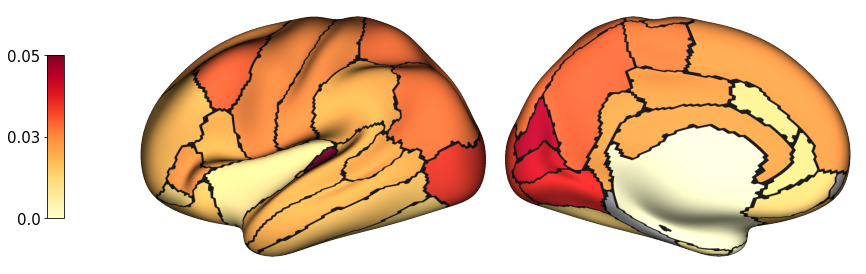

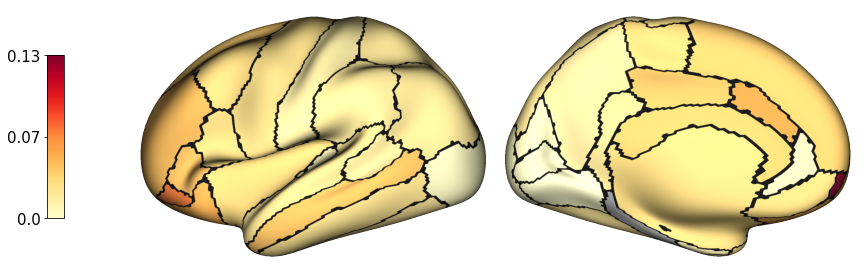

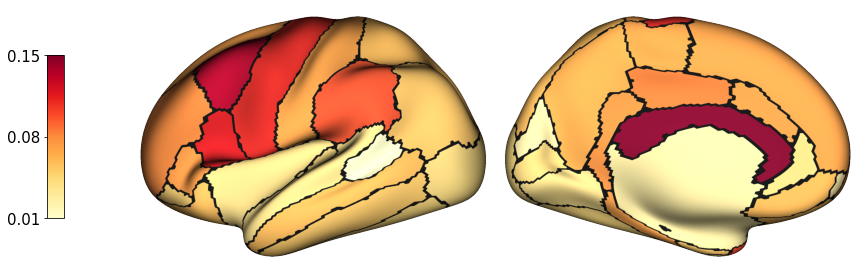

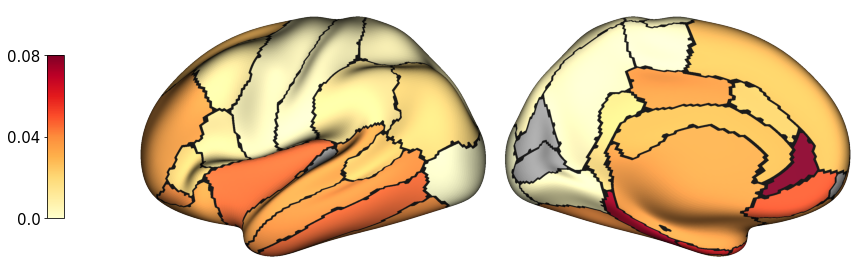

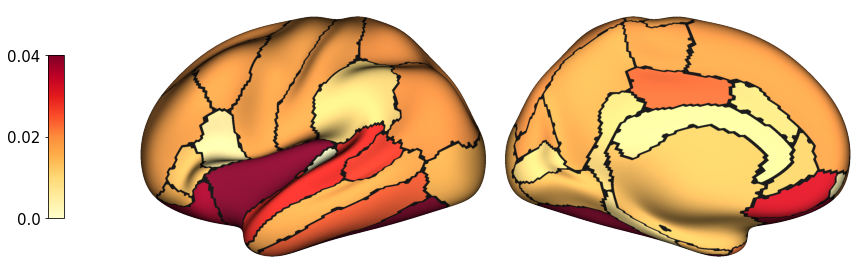

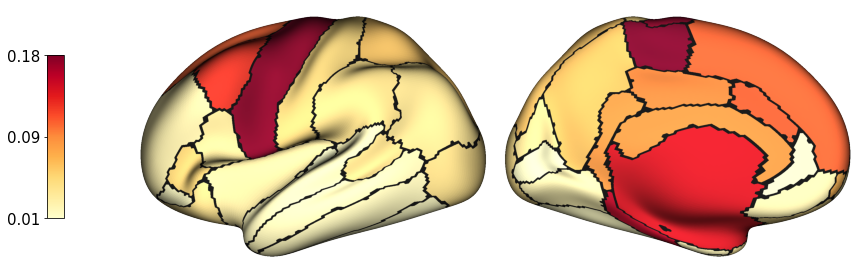

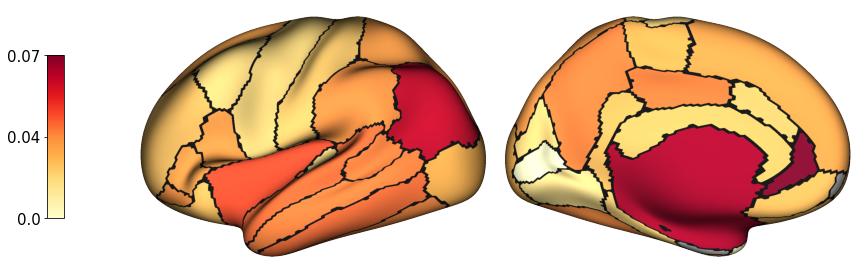

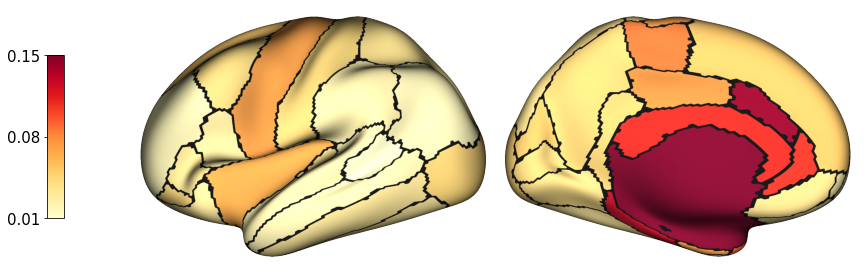

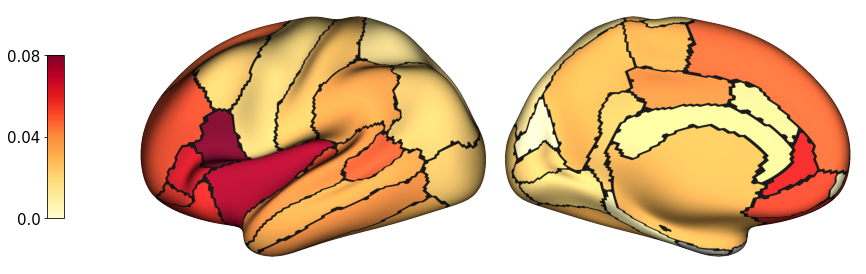

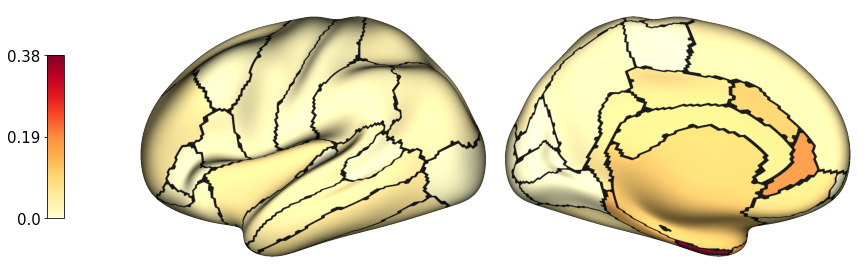

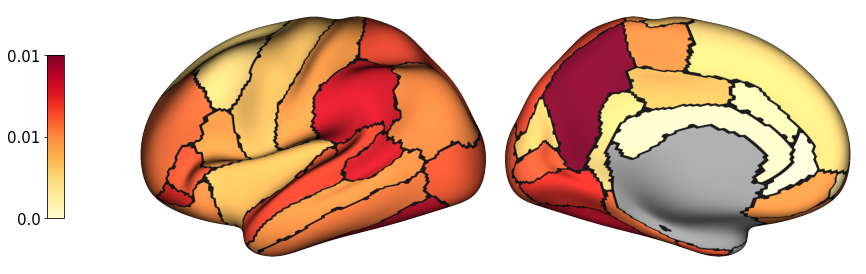

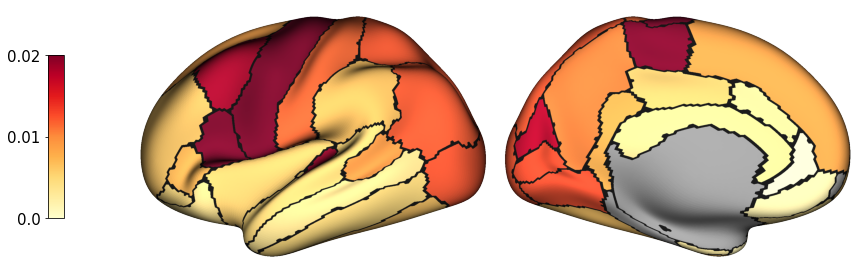

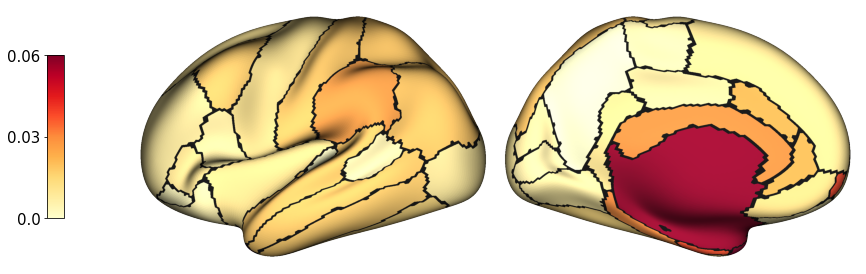

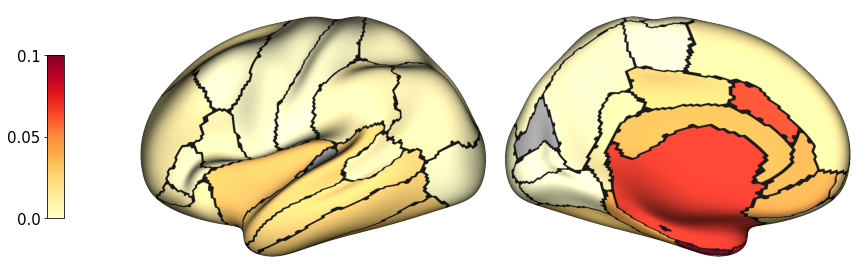

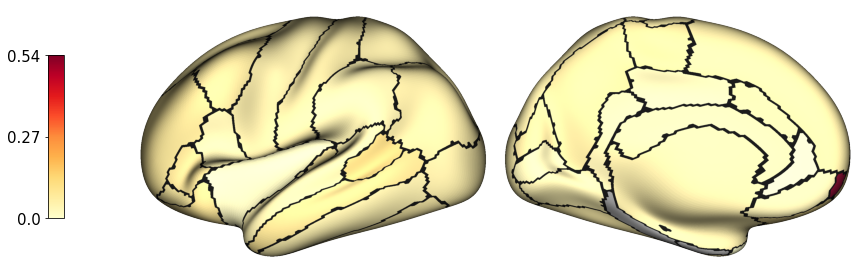

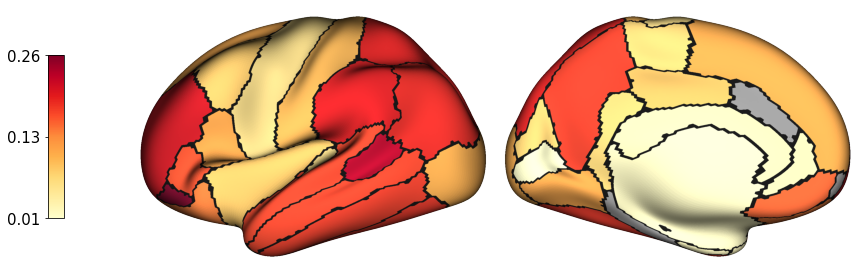

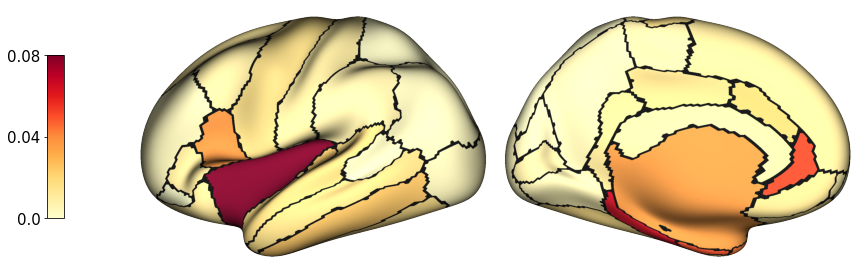

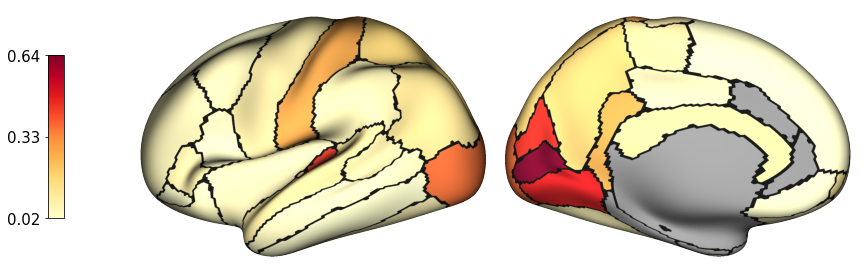

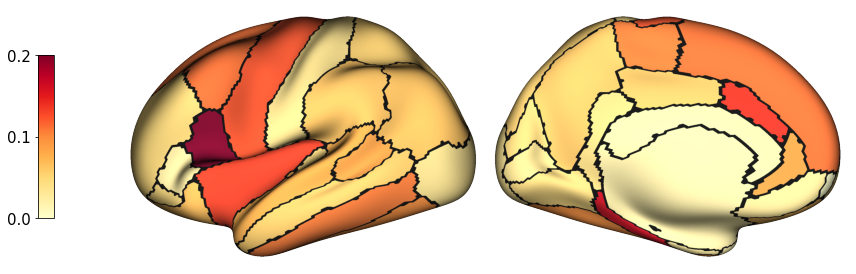

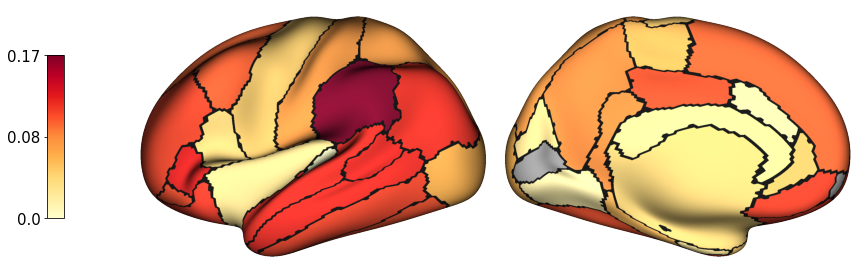

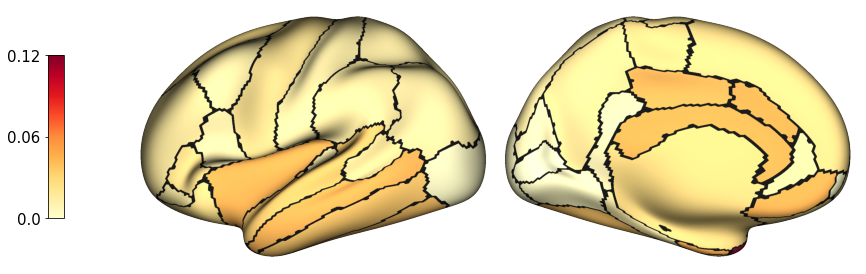

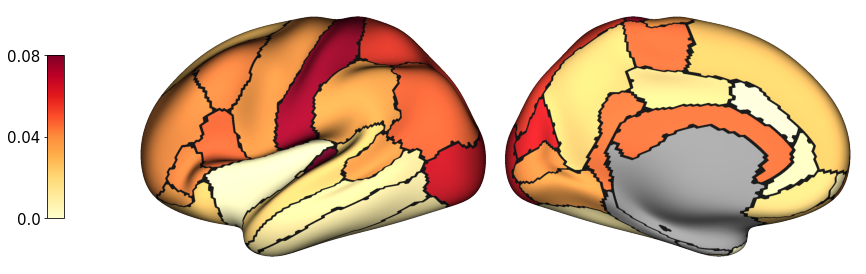

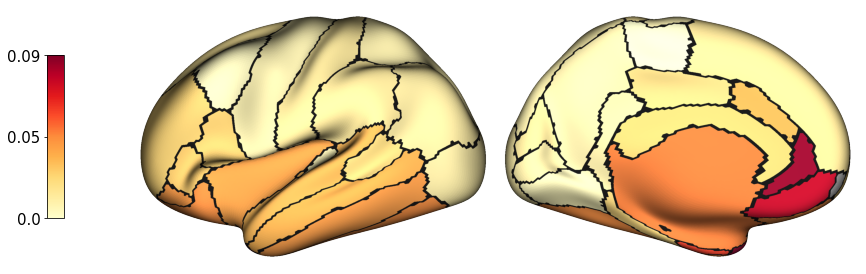

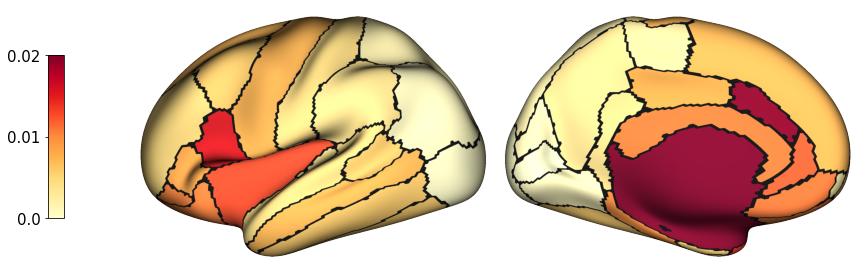

In [22]:
for cell_name in list(df_vis.keys()):
    this_lh = jorstad_fslr32k[cell_name][0:vertex_per_hemi]
    plot_cell_map_lh(cell_name, this_lh, figure_dir)

## 3. Compute the correlation
### The empirical correlation

In [23]:
# read in the neuroimaging file
VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas = pd.read_csv(imaging_dir+'/VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas.csv',header=0,index_col=0)
VUMC_SurfaceArea_CohensdGrpDiffs_DKatlas = pd.read_csv(imaging_dir+'/VUMC_SurfaceArea_CohensdGrpDiffs_DKatlas.csv',header=0,index_col=0)

In [24]:
def reorder_L_R(df):
    # Create a boolean mask to separate "L_" and "R_" rows
    L_rows = df[df.index.str.startswith("L_")]
    R_rows = df[df.index.str.startswith("R_")]
    
    # Concatenate them back, maintaining their original order
    df_LR = pd.concat([L_rows, R_rows])
    return df_LR

In [25]:
VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas

subgroup1-subgroup2  subgroup1-control  \
dk_region                                                           
L_bankssts                               0.542             -0.090   
R_bankssts                               0.401             -0.190   
L_caudalanteriorcingulate                0.247             -0.045   
R_caudalanteriorcingulate                0.081             -0.150   
L_caudalmiddlefrontal                    0.305             -0.157   
...                                        ...                ...   
R_temporalpole                           0.107             -0.038   
L_transversetemporal                     0.318             -0.162   
R_transversetemporal                     0.375             -0.242   
L_insula                                 0.242             -0.104   
R_insula                                 0.272             -0.055   

                           subgroup2-control  
dk_region                                     
L_bankssts                            -0.633  
R_bankssts                            -0.590  
L_caudalanteriorcingulate             -0.293  
R_caudalanteriorcingulate             -0.230  
L_caudalmiddlefrontal                 -0.462  
...                                      ...  
R_temporalpole                        -0.146  
L_transversetemporal                  -0.480  
R_transversetemporal                  -0.617  
L_insula                              -0.346  
R_insula                              -0.327  

[68 rows x 3 columns]

In [26]:
CorticalThickness_DK = reorder_L_R(VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas)
CorticalThickness_DK.to_csv(imaging_dir+'/VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas_reordered.csv',header=True,index=True)

SurfaceArea_DK = reorder_L_R(VUMC_SurfaceArea_CohensdGrpDiffs_DKatlas)
SurfaceArea_DK.to_csv(imaging_dir+'/VUMC_SurfaceArea_CohensdGrpDiffs_DKatlas_reordered.csv',header=True,index=True)

In [27]:
CorticalThickness_DK

subgroup1-subgroup2  subgroup1-control  \
dk_region                                                           
L_bankssts                               0.542             -0.090   
L_caudalanteriorcingulate                0.247             -0.045   
L_caudalmiddlefrontal                    0.305             -0.157   
L_cuneus                                 0.337              0.096   
L_entorhinal                             0.226              0.100   
...                                        ...                ...   
R_supramarginal                          0.520             -0.120   
R_frontalpole                            0.115              0.034   
R_temporalpole                           0.107             -0.038   
R_transversetemporal                     0.375             -0.242   
R_insula                                 0.272             -0.055   

                           subgroup2-control  
dk_region                                     
L_bankssts                            -0.633  
L_caudalanteriorcingulate             -0.293  
L_caudalmiddlefrontal                 -0.462  
L_cuneus                              -0.241  
L_entorhinal                          -0.126  
...                                      ...  
R_supramarginal                       -0.640  
R_frontalpole                         -0.081  
R_temporalpole                        -0.146  
R_transversetemporal                  -0.617  
R_insula                              -0.327  

[68 rows x 3 columns]

In [28]:
def cell_imag_corr(df1, df2, outdir_cor, outdir_p):
    # Compute Spearman correlation and p-values
    correlation_matrix = np.zeros((df1.shape[1], df2.shape[1]))
    p_value_matrix = np.zeros((df1.shape[1], df2.shape[1]))

    for i, col1 in enumerate(df1.columns):
        for j, col2 in enumerate(df2.columns):
            corr, p_val = stats.spearmanr(df1[col1], df2[col2])
            correlation_matrix[i, j] = corr
            p_value_matrix[i, j] = p_val

    # Convert to DataFrame for easier plotting
    correlation_df = pd.DataFrame(correlation_matrix, index=df1.columns, columns=df2.columns)
    p_value_df = pd.DataFrame(p_value_matrix, index=df1.columns, columns=df2.columns)
    correlation_df.to_csv(outdir_cor,header=True,index=True)
    p_value_df.to_csv(outdir_p,header=True,index=True)

    # Create a heatmap
    plt.figure(figsize=(24, 8))
    ax = sns.heatmap(correlation_df, annot=p_value_df.applymap(lambda x: f"{x:.3f}"), fmt='', 
                     cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})

    # Add title
    plt.title("Spearman Correlation Heatmap (with p-values)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the heatmap
    plt.show()

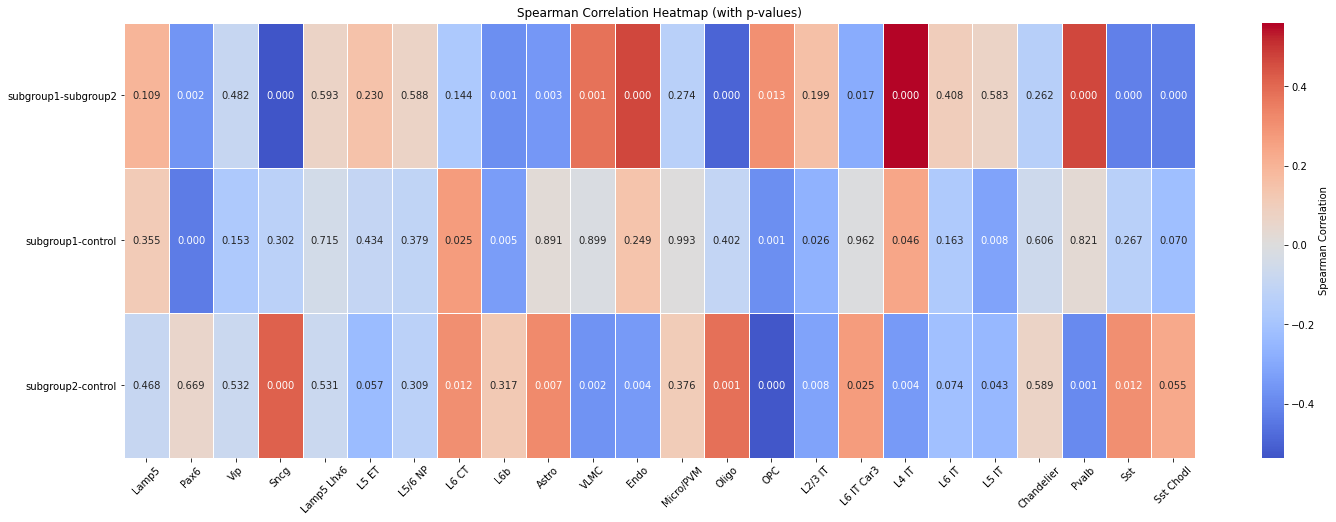

In [29]:
outdir_cor = base_dir+'/para/results/CorticalThickness_Jorstad_corr.csv'
outdir_p = base_dir+'/para/results/CorticalThickness_Jorstad_p.csv'
cell_imag_corr(CorticalThickness_DK,df_cor,outdir_cor,outdir_p)

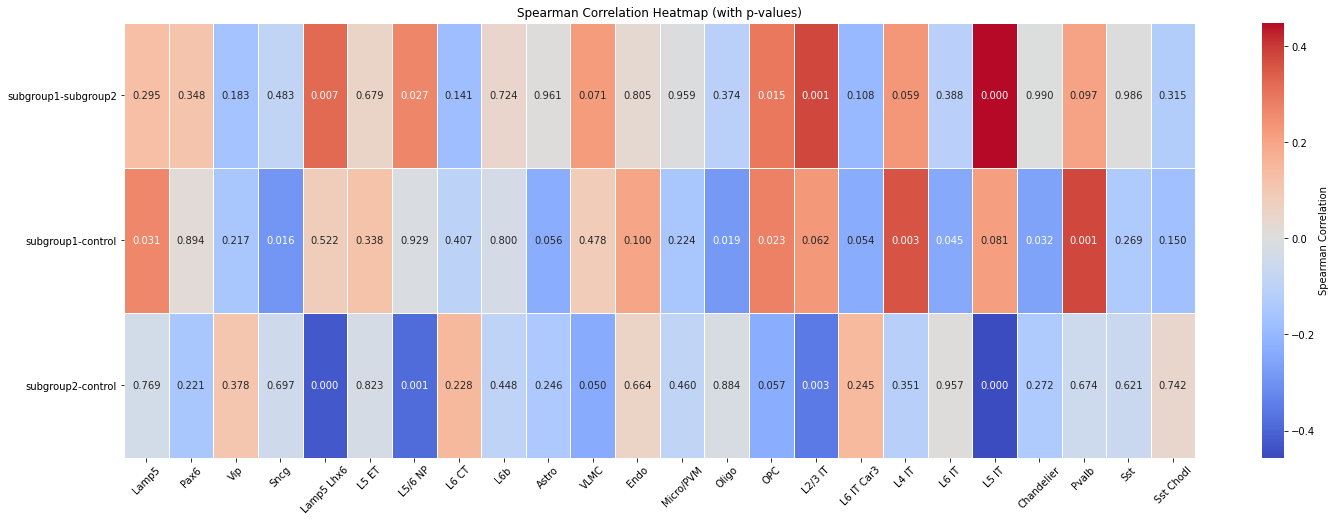

In [30]:
outdir_cor = base_dir+'/para/results/SurfaceArea_DK_Jorstad_corr.csv'
outdir_p = base_dir+'/para/results/SurfaceArea_DK_Jorstad_p.csv'
cell_imag_corr(SurfaceArea_DK,df_cor,outdir_cor,outdir_p)

### Permutate
Baum, https://markello-spatialnulls.netlify.app/spatial_nulls.html
Benefit of this method is we just need to spin the parcel for 10000 times then apply such assignments to each cell type. This way we can save computing time.

This method requires fsaverage as surface, so we will:
1. assign DK parcels to fsaverage5
2. use Baum to generate 10000 null models for DK parcel assignments
3. Apply each of the cell type fractions to the 10000 null aasignments

In [360]:
# ------------------------------
# STEP 1: Map DK parcels to vertex
# ------------------------------
# Extract cell types names
cell_types = list(df_vis.keys())

jorstad_fsa5 = {}  # Initialize dictionary for surface-mapped data

for this_cell in range(len(cell_types)):  # Iterate over all cell types
    cell_name = cell_types[this_cell]

    # Map DK parcellated data to fs surface
    jorstad_fsa5[cell_name] = parcel_to_surface(df_vis[cell_name].values, 'aparc_fsa5')
    
# ------------------------------
# STEP 2: LOAD DK ATLAS from FreeSurfer `.annot` files for fsaverage
# ------------------------------
lh_annot_path = "/Applications/freesurfer/7.2.0/subjects/fsaverage5/label/lh.aparc.annot"
rh_annot_path = "/Applications/freesurfer/7.2.0/subjects/fsaverage5/label/rh.aparc.annot"
    
# ------------------------------
# STEP 3: Spin null models
# ------------------------------
spins = freesurfer.spin_parcels(lhannot=lh_annot_path, rhannot=rh_annot_path,n_rotate=10000,
                                 version='fsaverage5',verbose=True)
# loop through the 24 cell types
for this_cell in cell_types:
    print(this_cell)
    brain = jorstad_fsa5[this_cell]
    nulls = brain[spins]
    nulls[spins == -1] = np.nan
    this_cell = this_cell.replace('/','.')
    file_name = '/Null_' + this_cell + '_DK.csv'
    file_path = cell_dir + file_name
    pd.DataFrame(nulls).to_csv(file_path)

                            00Calculating parcel overlap:     0/1000Calculating parcel overlap:     1/1000Calculating parcel overlap:     2/1000Calculating parcel overlap:     3/1000Calculating parcel overlap:     4/1000Calculating parcel overlap:     5/1000Calculating parcel overlap:     6/1000Calculating parcel overlap:     7/1000Calculating parcel overlap:     8/1000Calculating parcel overlap:     9/1000Calculating parcel overlap:    10/1000Calculating parcel overlap:    11/1000Calculating parcel overlap:    12/1000Calculating parcel overlap:    13/1000Calculating parcel overlap:    14/1000Calculating parcel overlap:    15/1000Calculating parcel overlap:    16/1000Calculating parcel overlap:    17/1000Calculating parcel overlap:    18/1000Calculating parcel overlap:    19/1000Calculating parcel overlap:    20/1000Calculating parcel overlap:    21/1000Calculating parcel overlap:    22/1000Calculating parcel overlap:    23/1000Calculating parcel overlap:    24/1000Calculating parcel o

Calculating parcel overlap:   215/1000Calculating parcel overlap:   216/1000Calculating parcel overlap:   217/1000Calculating parcel overlap:   218/1000Calculating parcel overlap:   219/1000Calculating parcel overlap:   220/1000Calculating parcel overlap:   221/1000Calculating parcel overlap:   222/1000Calculating parcel overlap:   223/1000Calculating parcel overlap:   224/1000Calculating parcel overlap:   225/1000Calculating parcel overlap:   226/1000Calculating parcel overlap:   227/1000Calculating parcel overlap:   228/1000Calculating parcel overlap:   229/1000Calculating parcel overlap:   230/1000Calculating parcel overlap:   231/1000Calculating parcel overlap:   232/1000Calculating parcel overlap:   233/1000Calculating parcel overlap:   234/1000Calculating parcel overlap:   235/1000Calculating parcel overlap:   236/1000Calculating parcel overlap:   237/1000Calculating parcel overlap:   238/1000Calculating parcel overlap:   239/1000Calculating parcel overlap:   240/1000Calculating 

Calculating parcel overlap:   431/1000Calculating parcel overlap:   432/1000Calculating parcel overlap:   433/1000Calculating parcel overlap:   434/1000Calculating parcel overlap:   435/1000Calculating parcel overlap:   436/1000Calculating parcel overlap:   437/1000Calculating parcel overlap:   438/1000Calculating parcel overlap:   439/1000Calculating parcel overlap:   440/1000Calculating parcel overlap:   441/1000Calculating parcel overlap:   442/1000Calculating parcel overlap:   443/1000Calculating parcel overlap:   444/1000Calculating parcel overlap:   445/1000Calculating parcel overlap:   446/1000Calculating parcel overlap:   447/1000Calculating parcel overlap:   448/1000Calculating parcel overlap:   449/1000Calculating parcel overlap:   450/1000Calculating parcel overlap:   451/1000Calculating parcel overlap:   452/1000Calculating parcel overlap:   453/1000Calculating parcel overlap:   454/1000Calculating parcel overlap:   455/1000Calculating parcel overlap:   456/1000Calculating 

Calculating parcel overlap:   647/1000Calculating parcel overlap:   648/1000Calculating parcel overlap:   649/1000Calculating parcel overlap:   650/1000Calculating parcel overlap:   651/1000Calculating parcel overlap:   652/1000Calculating parcel overlap:   653/1000Calculating parcel overlap:   654/1000Calculating parcel overlap:   655/1000Calculating parcel overlap:   656/1000Calculating parcel overlap:   657/1000Calculating parcel overlap:   658/1000Calculating parcel overlap:   659/1000Calculating parcel overlap:   660/1000Calculating parcel overlap:   661/1000Calculating parcel overlap:   662/1000Calculating parcel overlap:   663/1000Calculating parcel overlap:   664/1000Calculating parcel overlap:   665/1000Calculating parcel overlap:   666/1000Calculating parcel overlap:   667/1000Calculating parcel overlap:   668/1000Calculating parcel overlap:   669/1000Calculating parcel overlap:   670/1000Calculating parcel overlap:   671/1000Calculating parcel overlap:   672/1000Calculating 

Calculating parcel overlap:   863/1000Calculating parcel overlap:   864/1000Calculating parcel overlap:   865/1000Calculating parcel overlap:   866/1000Calculating parcel overlap:   867/1000Calculating parcel overlap:   868/1000Calculating parcel overlap:   869/1000Calculating parcel overlap:   870/1000Calculating parcel overlap:   871/1000Calculating parcel overlap:   872/1000Calculating parcel overlap:   873/1000Calculating parcel overlap:   874/1000Calculating parcel overlap:   875/1000Calculating parcel overlap:   876/1000Calculating parcel overlap:   877/1000Calculating parcel overlap:   878/1000Calculating parcel overlap:   879/1000Calculating parcel overlap:   880/1000Calculating parcel overlap:   881/1000Calculating parcel overlap:   882/1000Calculating parcel overlap:   883/1000Calculating parcel overlap:   884/1000Calculating parcel overlap:   885/1000Calculating parcel overlap:   886/1000Calculating parcel overlap:   887/1000Calculating parcel overlap:   888/1000Calculating 

Calculating parcel overlap:  1079/1000Calculating parcel overlap:  1080/1000Calculating parcel overlap:  1081/1000Calculating parcel overlap:  1082/1000Calculating parcel overlap:  1083/1000Calculating parcel overlap:  1084/1000Calculating parcel overlap:  1085/1000Calculating parcel overlap:  1086/1000Calculating parcel overlap:  1087/1000Calculating parcel overlap:  1088/1000Calculating parcel overlap:  1089/1000Calculating parcel overlap:  1090/1000Calculating parcel overlap:  1091/1000Calculating parcel overlap:  1092/1000Calculating parcel overlap:  1093/1000Calculating parcel overlap:  1094/1000Calculating parcel overlap:  1095/1000Calculating parcel overlap:  1096/1000Calculating parcel overlap:  1097/1000Calculating parcel overlap:  1098/1000Calculating parcel overlap:  1099/1000Calculating parcel overlap:  1100/1000Calculating parcel overlap:  1101/1000Calculating parcel overlap:  1102/1000Calculating parcel overlap:  1103/1000Calculating parcel overlap:  1104/1000Calculating 

Calculating parcel overlap:  1295/1000Calculating parcel overlap:  1296/1000Calculating parcel overlap:  1297/1000Calculating parcel overlap:  1298/1000Calculating parcel overlap:  1299/1000Calculating parcel overlap:  1300/1000Calculating parcel overlap:  1301/1000Calculating parcel overlap:  1302/1000Calculating parcel overlap:  1303/1000Calculating parcel overlap:  1304/1000Calculating parcel overlap:  1305/1000Calculating parcel overlap:  1306/1000Calculating parcel overlap:  1307/1000Calculating parcel overlap:  1308/1000Calculating parcel overlap:  1309/1000Calculating parcel overlap:  1310/1000Calculating parcel overlap:  1311/1000Calculating parcel overlap:  1312/1000Calculating parcel overlap:  1313/1000Calculating parcel overlap:  1314/1000Calculating parcel overlap:  1315/1000Calculating parcel overlap:  1316/1000Calculating parcel overlap:  1317/1000Calculating parcel overlap:  1318/1000Calculating parcel overlap:  1319/1000Calculating parcel overlap:  1320/1000Calculating 

Calculating parcel overlap:  1511/1000Calculating parcel overlap:  1512/1000Calculating parcel overlap:  1513/1000Calculating parcel overlap:  1514/1000Calculating parcel overlap:  1515/1000Calculating parcel overlap:  1516/1000Calculating parcel overlap:  1517/1000Calculating parcel overlap:  1518/1000Calculating parcel overlap:  1519/1000Calculating parcel overlap:  1520/1000Calculating parcel overlap:  1521/1000Calculating parcel overlap:  1522/1000Calculating parcel overlap:  1523/1000Calculating parcel overlap:  1524/1000Calculating parcel overlap:  1525/1000Calculating parcel overlap:  1526/1000Calculating parcel overlap:  1527/1000Calculating parcel overlap:  1528/1000Calculating parcel overlap:  1529/1000Calculating parcel overlap:  1530/1000Calculating parcel overlap:  1531/1000Calculating parcel overlap:  1532/1000Calculating parcel overlap:  1533/1000Calculating parcel overlap:  1534/1000Calculating parcel overlap:  1535/1000Calculating parcel overlap:  1536/1000Calculating 

Calculating parcel overlap:  1727/1000Calculating parcel overlap:  1728/1000Calculating parcel overlap:  1729/1000Calculating parcel overlap:  1730/1000Calculating parcel overlap:  1731/1000Calculating parcel overlap:  1732/1000Calculating parcel overlap:  1733/1000Calculating parcel overlap:  1734/1000Calculating parcel overlap:  1735/1000Calculating parcel overlap:  1736/1000Calculating parcel overlap:  1737/1000Calculating parcel overlap:  1738/1000Calculating parcel overlap:  1739/1000Calculating parcel overlap:  1740/1000Calculating parcel overlap:  1741/1000Calculating parcel overlap:  1742/1000Calculating parcel overlap:  1743/1000Calculating parcel overlap:  1744/1000Calculating parcel overlap:  1745/1000Calculating parcel overlap:  1746/1000Calculating parcel overlap:  1747/1000Calculating parcel overlap:  1748/1000Calculating parcel overlap:  1749/1000Calculating parcel overlap:  1750/1000Calculating parcel overlap:  1751/1000Calculating parcel overlap:  1752/1000Calculating 

Calculating parcel overlap:  1943/1000Calculating parcel overlap:  1944/1000Calculating parcel overlap:  1945/1000Calculating parcel overlap:  1946/1000Calculating parcel overlap:  1947/1000Calculating parcel overlap:  1948/1000Calculating parcel overlap:  1949/1000Calculating parcel overlap:  1950/1000Calculating parcel overlap:  1951/1000Calculating parcel overlap:  1952/1000Calculating parcel overlap:  1953/1000Calculating parcel overlap:  1954/1000Calculating parcel overlap:  1955/1000Calculating parcel overlap:  1956/1000Calculating parcel overlap:  1957/1000Calculating parcel overlap:  1958/1000Calculating parcel overlap:  1959/1000Calculating parcel overlap:  1960/1000Calculating parcel overlap:  1961/1000Calculating parcel overlap:  1962/1000Calculating parcel overlap:  1963/1000Calculating parcel overlap:  1964/1000Calculating parcel overlap:  1965/1000Calculating parcel overlap:  1966/1000Calculating parcel overlap:  1967/1000Calculating parcel overlap:  1968/1000Calculating 

Calculating parcel overlap:  2159/1000Calculating parcel overlap:  2160/1000Calculating parcel overlap:  2161/1000Calculating parcel overlap:  2162/1000Calculating parcel overlap:  2163/1000Calculating parcel overlap:  2164/1000Calculating parcel overlap:  2165/1000Calculating parcel overlap:  2166/1000Calculating parcel overlap:  2167/1000Calculating parcel overlap:  2168/1000Calculating parcel overlap:  2169/1000Calculating parcel overlap:  2170/1000Calculating parcel overlap:  2171/1000Calculating parcel overlap:  2172/1000Calculating parcel overlap:  2173/1000Calculating parcel overlap:  2174/1000Calculating parcel overlap:  2175/1000Calculating parcel overlap:  2176/1000Calculating parcel overlap:  2177/1000Calculating parcel overlap:  2178/1000Calculating parcel overlap:  2179/1000Calculating parcel overlap:  2180/1000Calculating parcel overlap:  2181/1000Calculating parcel overlap:  2182/1000Calculating parcel overlap:  2183/1000Calculating parcel overlap:  2184/1000Calculating 

Calculating parcel overlap:  2375/1000Calculating parcel overlap:  2376/1000Calculating parcel overlap:  2377/1000Calculating parcel overlap:  2378/1000Calculating parcel overlap:  2379/1000Calculating parcel overlap:  2380/1000Calculating parcel overlap:  2381/1000Calculating parcel overlap:  2382/1000Calculating parcel overlap:  2383/1000Calculating parcel overlap:  2384/1000Calculating parcel overlap:  2385/1000Calculating parcel overlap:  2386/1000Calculating parcel overlap:  2387/1000Calculating parcel overlap:  2388/1000Calculating parcel overlap:  2389/1000Calculating parcel overlap:  2390/1000Calculating parcel overlap:  2391/1000Calculating parcel overlap:  2392/1000Calculating parcel overlap:  2393/1000Calculating parcel overlap:  2394/1000Calculating parcel overlap:  2395/1000Calculating parcel overlap:  2396/1000Calculating parcel overlap:  2397/1000Calculating parcel overlap:  2398/1000Calculating parcel overlap:  2399/1000Calculating parcel overlap:  2400/1000Calculating 

Calculating parcel overlap:  2591/1000Calculating parcel overlap:  2592/1000Calculating parcel overlap:  2593/1000Calculating parcel overlap:  2594/1000Calculating parcel overlap:  2595/1000Calculating parcel overlap:  2596/1000Calculating parcel overlap:  2597/1000Calculating parcel overlap:  2598/1000Calculating parcel overlap:  2599/1000Calculating parcel overlap:  2600/1000Calculating parcel overlap:  2601/1000Calculating parcel overlap:  2602/1000Calculating parcel overlap:  2603/1000Calculating parcel overlap:  2604/1000Calculating parcel overlap:  2605/1000Calculating parcel overlap:  2606/1000Calculating parcel overlap:  2607/1000Calculating parcel overlap:  2608/1000Calculating parcel overlap:  2609/1000Calculating parcel overlap:  2610/1000Calculating parcel overlap:  2611/1000Calculating parcel overlap:  2612/1000Calculating parcel overlap:  2613/1000Calculating parcel overlap:  2614/1000Calculating parcel overlap:  2615/1000Calculating parcel overlap:  2616/1000Calculating 

Calculating parcel overlap:  2807/1000Calculating parcel overlap:  2808/1000Calculating parcel overlap:  2809/1000Calculating parcel overlap:  2810/1000Calculating parcel overlap:  2811/1000Calculating parcel overlap:  2812/1000Calculating parcel overlap:  2813/1000Calculating parcel overlap:  2814/1000Calculating parcel overlap:  2815/1000Calculating parcel overlap:  2816/1000Calculating parcel overlap:  2817/1000Calculating parcel overlap:  2818/1000Calculating parcel overlap:  2819/1000Calculating parcel overlap:  2820/1000Calculating parcel overlap:  2821/1000Calculating parcel overlap:  2822/1000Calculating parcel overlap:  2823/1000Calculating parcel overlap:  2824/1000Calculating parcel overlap:  2825/1000Calculating parcel overlap:  2826/1000Calculating parcel overlap:  2827/1000Calculating parcel overlap:  2828/1000Calculating parcel overlap:  2829/1000Calculating parcel overlap:  2830/1000Calculating parcel overlap:  2831/1000Calculating parcel overlap:  2832/1000Calculating 

Calculating parcel overlap:  3023/1000Calculating parcel overlap:  3024/1000Calculating parcel overlap:  3025/1000Calculating parcel overlap:  3026/1000Calculating parcel overlap:  3027/1000Calculating parcel overlap:  3028/1000Calculating parcel overlap:  3029/1000Calculating parcel overlap:  3030/1000Calculating parcel overlap:  3031/1000Calculating parcel overlap:  3032/1000Calculating parcel overlap:  3033/1000Calculating parcel overlap:  3034/1000Calculating parcel overlap:  3035/1000Calculating parcel overlap:  3036/1000Calculating parcel overlap:  3037/1000Calculating parcel overlap:  3038/1000Calculating parcel overlap:  3039/1000Calculating parcel overlap:  3040/1000Calculating parcel overlap:  3041/1000Calculating parcel overlap:  3042/1000Calculating parcel overlap:  3043/1000Calculating parcel overlap:  3044/1000Calculating parcel overlap:  3045/1000Calculating parcel overlap:  3046/1000Calculating parcel overlap:  3047/1000Calculating parcel overlap:  3048/1000Calculating 

Calculating parcel overlap:  3239/1000Calculating parcel overlap:  3240/1000Calculating parcel overlap:  3241/1000Calculating parcel overlap:  3242/1000Calculating parcel overlap:  3243/1000Calculating parcel overlap:  3244/1000Calculating parcel overlap:  3245/1000Calculating parcel overlap:  3246/1000Calculating parcel overlap:  3247/1000Calculating parcel overlap:  3248/1000Calculating parcel overlap:  3249/1000Calculating parcel overlap:  3250/1000Calculating parcel overlap:  3251/1000Calculating parcel overlap:  3252/1000Calculating parcel overlap:  3253/1000Calculating parcel overlap:  3254/1000Calculating parcel overlap:  3255/1000Calculating parcel overlap:  3256/1000Calculating parcel overlap:  3257/1000Calculating parcel overlap:  3258/1000Calculating parcel overlap:  3259/1000Calculating parcel overlap:  3260/1000Calculating parcel overlap:  3261/1000Calculating parcel overlap:  3262/1000Calculating parcel overlap:  3263/1000Calculating parcel overlap:  3264/1000Calculating 

Calculating parcel overlap:  3455/1000Calculating parcel overlap:  3456/1000Calculating parcel overlap:  3457/1000Calculating parcel overlap:  3458/1000Calculating parcel overlap:  3459/1000Calculating parcel overlap:  3460/1000Calculating parcel overlap:  3461/1000Calculating parcel overlap:  3462/1000Calculating parcel overlap:  3463/1000Calculating parcel overlap:  3464/1000Calculating parcel overlap:  3465/1000Calculating parcel overlap:  3466/1000Calculating parcel overlap:  3467/1000Calculating parcel overlap:  3468/1000Calculating parcel overlap:  3469/1000Calculating parcel overlap:  3470/1000Calculating parcel overlap:  3471/1000Calculating parcel overlap:  3472/1000Calculating parcel overlap:  3473/1000Calculating parcel overlap:  3474/1000Calculating parcel overlap:  3475/1000Calculating parcel overlap:  3476/1000Calculating parcel overlap:  3477/1000Calculating parcel overlap:  3478/1000Calculating parcel overlap:  3479/1000Calculating parcel overlap:  3480/1000Calculating 

Calculating parcel overlap:  3671/1000Calculating parcel overlap:  3672/1000Calculating parcel overlap:  3673/1000Calculating parcel overlap:  3674/1000Calculating parcel overlap:  3675/1000Calculating parcel overlap:  3676/1000Calculating parcel overlap:  3677/1000Calculating parcel overlap:  3678/1000Calculating parcel overlap:  3679/1000Calculating parcel overlap:  3680/1000Calculating parcel overlap:  3681/1000Calculating parcel overlap:  3682/1000Calculating parcel overlap:  3683/1000Calculating parcel overlap:  3684/1000Calculating parcel overlap:  3685/1000Calculating parcel overlap:  3686/1000Calculating parcel overlap:  3687/1000Calculating parcel overlap:  3688/1000Calculating parcel overlap:  3689/1000Calculating parcel overlap:  3690/1000Calculating parcel overlap:  3691/1000Calculating parcel overlap:  3692/1000Calculating parcel overlap:  3693/1000Calculating parcel overlap:  3694/1000Calculating parcel overlap:  3695/1000Calculating parcel overlap:  3696/1000Calculating 

Calculating parcel overlap:  3887/1000Calculating parcel overlap:  3888/1000Calculating parcel overlap:  3889/1000Calculating parcel overlap:  3890/1000Calculating parcel overlap:  3891/1000Calculating parcel overlap:  3892/1000Calculating parcel overlap:  3893/1000Calculating parcel overlap:  3894/1000Calculating parcel overlap:  3895/1000Calculating parcel overlap:  3896/1000Calculating parcel overlap:  3897/1000Calculating parcel overlap:  3898/1000Calculating parcel overlap:  3899/1000Calculating parcel overlap:  3900/1000Calculating parcel overlap:  3901/1000Calculating parcel overlap:  3902/1000Calculating parcel overlap:  3903/1000Calculating parcel overlap:  3904/1000Calculating parcel overlap:  3905/1000Calculating parcel overlap:  3906/1000Calculating parcel overlap:  3907/1000Calculating parcel overlap:  3908/1000Calculating parcel overlap:  3909/1000Calculating parcel overlap:  3910/1000Calculating parcel overlap:  3911/1000Calculating parcel overlap:  3912/1000Calculating 

Calculating parcel overlap:  4103/1000Calculating parcel overlap:  4104/1000Calculating parcel overlap:  4105/1000Calculating parcel overlap:  4106/1000Calculating parcel overlap:  4107/1000Calculating parcel overlap:  4108/1000Calculating parcel overlap:  4109/1000Calculating parcel overlap:  4110/1000Calculating parcel overlap:  4111/1000Calculating parcel overlap:  4112/1000Calculating parcel overlap:  4113/1000Calculating parcel overlap:  4114/1000Calculating parcel overlap:  4115/1000Calculating parcel overlap:  4116/1000Calculating parcel overlap:  4117/1000Calculating parcel overlap:  4118/1000Calculating parcel overlap:  4119/1000Calculating parcel overlap:  4120/1000Calculating parcel overlap:  4121/1000Calculating parcel overlap:  4122/1000Calculating parcel overlap:  4123/1000Calculating parcel overlap:  4124/1000Calculating parcel overlap:  4125/1000Calculating parcel overlap:  4126/1000Calculating parcel overlap:  4127/1000Calculating parcel overlap:  4128/1000Calculating 

Calculating parcel overlap:  4319/1000Calculating parcel overlap:  4320/1000Calculating parcel overlap:  4321/1000Calculating parcel overlap:  4322/1000Calculating parcel overlap:  4323/1000Calculating parcel overlap:  4324/1000Calculating parcel overlap:  4325/1000Calculating parcel overlap:  4326/1000Calculating parcel overlap:  4327/1000Calculating parcel overlap:  4328/1000Calculating parcel overlap:  4329/1000Calculating parcel overlap:  4330/1000Calculating parcel overlap:  4331/1000Calculating parcel overlap:  4332/1000Calculating parcel overlap:  4333/1000Calculating parcel overlap:  4334/1000Calculating parcel overlap:  4335/1000Calculating parcel overlap:  4336/1000Calculating parcel overlap:  4337/1000Calculating parcel overlap:  4338/1000Calculating parcel overlap:  4339/1000Calculating parcel overlap:  4340/1000Calculating parcel overlap:  4341/1000Calculating parcel overlap:  4342/1000Calculating parcel overlap:  4343/1000Calculating parcel overlap:  4344/1000Calculating 

Calculating parcel overlap:  4535/1000Calculating parcel overlap:  4536/1000Calculating parcel overlap:  4537/1000Calculating parcel overlap:  4538/1000Calculating parcel overlap:  4539/1000Calculating parcel overlap:  4540/1000Calculating parcel overlap:  4541/1000Calculating parcel overlap:  4542/1000Calculating parcel overlap:  4543/1000Calculating parcel overlap:  4544/1000Calculating parcel overlap:  4545/1000Calculating parcel overlap:  4546/1000Calculating parcel overlap:  4547/1000Calculating parcel overlap:  4548/1000Calculating parcel overlap:  4549/1000Calculating parcel overlap:  4550/1000Calculating parcel overlap:  4551/1000Calculating parcel overlap:  4552/1000Calculating parcel overlap:  4553/1000Calculating parcel overlap:  4554/1000Calculating parcel overlap:  4555/1000Calculating parcel overlap:  4556/1000Calculating parcel overlap:  4557/1000Calculating parcel overlap:  4558/1000Calculating parcel overlap:  4559/1000Calculating parcel overlap:  4560/1000Calculating 

Calculating parcel overlap:  4751/1000Calculating parcel overlap:  4752/1000Calculating parcel overlap:  4753/1000Calculating parcel overlap:  4754/1000Calculating parcel overlap:  4755/1000Calculating parcel overlap:  4756/1000Calculating parcel overlap:  4757/1000Calculating parcel overlap:  4758/1000Calculating parcel overlap:  4759/1000Calculating parcel overlap:  4760/1000Calculating parcel overlap:  4761/1000Calculating parcel overlap:  4762/1000Calculating parcel overlap:  4763/1000Calculating parcel overlap:  4764/1000Calculating parcel overlap:  4765/1000Calculating parcel overlap:  4766/1000Calculating parcel overlap:  4767/1000Calculating parcel overlap:  4768/1000Calculating parcel overlap:  4769/1000Calculating parcel overlap:  4770/1000Calculating parcel overlap:  4771/1000Calculating parcel overlap:  4772/1000Calculating parcel overlap:  4773/1000Calculating parcel overlap:  4774/1000Calculating parcel overlap:  4775/1000Calculating parcel overlap:  4776/1000Calculating 

Calculating parcel overlap:  4967/1000Calculating parcel overlap:  4968/1000Calculating parcel overlap:  4969/1000Calculating parcel overlap:  4970/1000Calculating parcel overlap:  4971/1000Calculating parcel overlap:  4972/1000Calculating parcel overlap:  4973/1000Calculating parcel overlap:  4974/1000Calculating parcel overlap:  4975/1000Calculating parcel overlap:  4976/1000Calculating parcel overlap:  4977/1000Calculating parcel overlap:  4978/1000Calculating parcel overlap:  4979/1000Calculating parcel overlap:  4980/1000Calculating parcel overlap:  4981/1000Calculating parcel overlap:  4982/1000Calculating parcel overlap:  4983/1000Calculating parcel overlap:  4984/1000Calculating parcel overlap:  4985/1000Calculating parcel overlap:  4986/1000Calculating parcel overlap:  4987/1000Calculating parcel overlap:  4988/1000Calculating parcel overlap:  4989/1000Calculating parcel overlap:  4990/1000Calculating parcel overlap:  4991/1000Calculating parcel overlap:  4992/1000Calculating 

Calculating parcel overlap:  5183/1000Calculating parcel overlap:  5184/1000Calculating parcel overlap:  5185/1000Calculating parcel overlap:  5186/1000Calculating parcel overlap:  5187/1000Calculating parcel overlap:  5188/1000Calculating parcel overlap:  5189/1000Calculating parcel overlap:  5190/1000Calculating parcel overlap:  5191/1000Calculating parcel overlap:  5192/1000Calculating parcel overlap:  5193/1000Calculating parcel overlap:  5194/1000Calculating parcel overlap:  5195/1000Calculating parcel overlap:  5196/1000Calculating parcel overlap:  5197/1000Calculating parcel overlap:  5198/1000Calculating parcel overlap:  5199/1000Calculating parcel overlap:  5200/1000Calculating parcel overlap:  5201/1000Calculating parcel overlap:  5202/1000Calculating parcel overlap:  5203/1000Calculating parcel overlap:  5204/1000Calculating parcel overlap:  5205/1000Calculating parcel overlap:  5206/1000Calculating parcel overlap:  5207/1000Calculating parcel overlap:  5208/1000Calculating 

Calculating parcel overlap:  5399/1000Calculating parcel overlap:  5400/1000Calculating parcel overlap:  5401/1000Calculating parcel overlap:  5402/1000Calculating parcel overlap:  5403/1000Calculating parcel overlap:  5404/1000Calculating parcel overlap:  5405/1000Calculating parcel overlap:  5406/1000Calculating parcel overlap:  5407/1000Calculating parcel overlap:  5408/1000Calculating parcel overlap:  5409/1000Calculating parcel overlap:  5410/1000Calculating parcel overlap:  5411/1000Calculating parcel overlap:  5412/1000Calculating parcel overlap:  5413/1000Calculating parcel overlap:  5414/1000Calculating parcel overlap:  5415/1000Calculating parcel overlap:  5416/1000Calculating parcel overlap:  5417/1000Calculating parcel overlap:  5418/1000Calculating parcel overlap:  5419/1000Calculating parcel overlap:  5420/1000Calculating parcel overlap:  5421/1000Calculating parcel overlap:  5422/1000Calculating parcel overlap:  5423/1000Calculating parcel overlap:  5424/1000Calculating 

Calculating parcel overlap:  5615/1000Calculating parcel overlap:  5616/1000Calculating parcel overlap:  5617/1000Calculating parcel overlap:  5618/1000Calculating parcel overlap:  5619/1000Calculating parcel overlap:  5620/1000Calculating parcel overlap:  5621/1000Calculating parcel overlap:  5622/1000Calculating parcel overlap:  5623/1000Calculating parcel overlap:  5624/1000Calculating parcel overlap:  5625/1000Calculating parcel overlap:  5626/1000Calculating parcel overlap:  5627/1000Calculating parcel overlap:  5628/1000Calculating parcel overlap:  5629/1000Calculating parcel overlap:  5630/1000Calculating parcel overlap:  5631/1000Calculating parcel overlap:  5632/1000Calculating parcel overlap:  5633/1000Calculating parcel overlap:  5634/1000Calculating parcel overlap:  5635/1000Calculating parcel overlap:  5636/1000Calculating parcel overlap:  5637/1000Calculating parcel overlap:  5638/1000Calculating parcel overlap:  5639/1000Calculating parcel overlap:  5640/1000Calculating 

Calculating parcel overlap:  5831/1000Calculating parcel overlap:  5832/1000Calculating parcel overlap:  5833/1000Calculating parcel overlap:  5834/1000Calculating parcel overlap:  5835/1000Calculating parcel overlap:  5836/1000Calculating parcel overlap:  5837/1000Calculating parcel overlap:  5838/1000Calculating parcel overlap:  5839/1000Calculating parcel overlap:  5840/1000Calculating parcel overlap:  5841/1000Calculating parcel overlap:  5842/1000Calculating parcel overlap:  5843/1000Calculating parcel overlap:  5844/1000Calculating parcel overlap:  5845/1000Calculating parcel overlap:  5846/1000Calculating parcel overlap:  5847/1000Calculating parcel overlap:  5848/1000Calculating parcel overlap:  5849/1000Calculating parcel overlap:  5850/1000Calculating parcel overlap:  5851/1000Calculating parcel overlap:  5852/1000Calculating parcel overlap:  5853/1000Calculating parcel overlap:  5854/1000Calculating parcel overlap:  5855/1000Calculating parcel overlap:  5856/1000Calculating 

Calculating parcel overlap:  6047/1000Calculating parcel overlap:  6048/1000Calculating parcel overlap:  6049/1000Calculating parcel overlap:  6050/1000Calculating parcel overlap:  6051/1000Calculating parcel overlap:  6052/1000Calculating parcel overlap:  6053/1000Calculating parcel overlap:  6054/1000Calculating parcel overlap:  6055/1000Calculating parcel overlap:  6056/1000Calculating parcel overlap:  6057/1000Calculating parcel overlap:  6058/1000Calculating parcel overlap:  6059/1000Calculating parcel overlap:  6060/1000Calculating parcel overlap:  6061/1000Calculating parcel overlap:  6062/1000Calculating parcel overlap:  6063/1000Calculating parcel overlap:  6064/1000Calculating parcel overlap:  6065/1000Calculating parcel overlap:  6066/1000Calculating parcel overlap:  6067/1000Calculating parcel overlap:  6068/1000Calculating parcel overlap:  6069/1000Calculating parcel overlap:  6070/1000Calculating parcel overlap:  6071/1000Calculating parcel overlap:  6072/1000Calculating 

Calculating parcel overlap:  6263/1000Calculating parcel overlap:  6264/1000Calculating parcel overlap:  6265/1000Calculating parcel overlap:  6266/1000Calculating parcel overlap:  6267/1000Calculating parcel overlap:  6268/1000Calculating parcel overlap:  6269/1000Calculating parcel overlap:  6270/1000Calculating parcel overlap:  6271/1000Calculating parcel overlap:  6272/1000Calculating parcel overlap:  6273/1000Calculating parcel overlap:  6274/1000Calculating parcel overlap:  6275/1000Calculating parcel overlap:  6276/1000Calculating parcel overlap:  6277/1000Calculating parcel overlap:  6278/1000Calculating parcel overlap:  6279/1000Calculating parcel overlap:  6280/1000Calculating parcel overlap:  6281/1000Calculating parcel overlap:  6282/1000Calculating parcel overlap:  6283/1000Calculating parcel overlap:  6284/1000Calculating parcel overlap:  6285/1000Calculating parcel overlap:  6286/1000Calculating parcel overlap:  6287/1000Calculating parcel overlap:  6288/1000Calculating 

Calculating parcel overlap:  6479/1000Calculating parcel overlap:  6480/1000Calculating parcel overlap:  6481/1000Calculating parcel overlap:  6482/1000Calculating parcel overlap:  6483/1000Calculating parcel overlap:  6484/1000Calculating parcel overlap:  6485/1000Calculating parcel overlap:  6486/1000Calculating parcel overlap:  6487/1000Calculating parcel overlap:  6488/1000Calculating parcel overlap:  6489/1000Calculating parcel overlap:  6490/1000Calculating parcel overlap:  6491/1000Calculating parcel overlap:  6492/1000Calculating parcel overlap:  6493/1000Calculating parcel overlap:  6494/1000Calculating parcel overlap:  6495/1000Calculating parcel overlap:  6496/1000Calculating parcel overlap:  6497/1000Calculating parcel overlap:  6498/1000Calculating parcel overlap:  6499/1000Calculating parcel overlap:  6500/1000Calculating parcel overlap:  6501/1000Calculating parcel overlap:  6502/1000Calculating parcel overlap:  6503/1000Calculating parcel overlap:  6504/1000Calculating 

Calculating parcel overlap:  6695/1000Calculating parcel overlap:  6696/1000Calculating parcel overlap:  6697/1000Calculating parcel overlap:  6698/1000Calculating parcel overlap:  6699/1000Calculating parcel overlap:  6700/1000Calculating parcel overlap:  6701/1000Calculating parcel overlap:  6702/1000Calculating parcel overlap:  6703/1000Calculating parcel overlap:  6704/1000Calculating parcel overlap:  6705/1000Calculating parcel overlap:  6706/1000Calculating parcel overlap:  6707/1000Calculating parcel overlap:  6708/1000Calculating parcel overlap:  6709/1000Calculating parcel overlap:  6710/1000Calculating parcel overlap:  6711/1000Calculating parcel overlap:  6712/1000Calculating parcel overlap:  6713/1000Calculating parcel overlap:  6714/1000Calculating parcel overlap:  6715/1000Calculating parcel overlap:  6716/1000Calculating parcel overlap:  6717/1000Calculating parcel overlap:  6718/1000Calculating parcel overlap:  6719/1000Calculating parcel overlap:  6720/1000Calculating 

Calculating parcel overlap:  6911/1000Calculating parcel overlap:  6912/1000Calculating parcel overlap:  6913/1000Calculating parcel overlap:  6914/1000Calculating parcel overlap:  6915/1000Calculating parcel overlap:  6916/1000Calculating parcel overlap:  6917/1000Calculating parcel overlap:  6918/1000Calculating parcel overlap:  6919/1000Calculating parcel overlap:  6920/1000Calculating parcel overlap:  6921/1000Calculating parcel overlap:  6922/1000Calculating parcel overlap:  6923/1000Calculating parcel overlap:  6924/1000Calculating parcel overlap:  6925/1000Calculating parcel overlap:  6926/1000Calculating parcel overlap:  6927/1000Calculating parcel overlap:  6928/1000Calculating parcel overlap:  6929/1000Calculating parcel overlap:  6930/1000Calculating parcel overlap:  6931/1000Calculating parcel overlap:  6932/1000Calculating parcel overlap:  6933/1000Calculating parcel overlap:  6934/1000Calculating parcel overlap:  6935/1000Calculating parcel overlap:  6936/1000Calculating 

Calculating parcel overlap:  7127/1000Calculating parcel overlap:  7128/1000Calculating parcel overlap:  7129/1000Calculating parcel overlap:  7130/1000Calculating parcel overlap:  7131/1000Calculating parcel overlap:  7132/1000Calculating parcel overlap:  7133/1000Calculating parcel overlap:  7134/1000Calculating parcel overlap:  7135/1000Calculating parcel overlap:  7136/1000Calculating parcel overlap:  7137/1000Calculating parcel overlap:  7138/1000Calculating parcel overlap:  7139/1000Calculating parcel overlap:  7140/1000Calculating parcel overlap:  7141/1000Calculating parcel overlap:  7142/1000Calculating parcel overlap:  7143/1000Calculating parcel overlap:  7144/1000Calculating parcel overlap:  7145/1000Calculating parcel overlap:  7146/1000Calculating parcel overlap:  7147/1000Calculating parcel overlap:  7148/1000Calculating parcel overlap:  7149/1000Calculating parcel overlap:  7150/1000Calculating parcel overlap:  7151/1000Calculating parcel overlap:  7152/1000Calculating 

Calculating parcel overlap:  7343/1000Calculating parcel overlap:  7344/1000Calculating parcel overlap:  7345/1000Calculating parcel overlap:  7346/1000Calculating parcel overlap:  7347/1000Calculating parcel overlap:  7348/1000Calculating parcel overlap:  7349/1000Calculating parcel overlap:  7350/1000Calculating parcel overlap:  7351/1000Calculating parcel overlap:  7352/1000Calculating parcel overlap:  7353/1000Calculating parcel overlap:  7354/1000Calculating parcel overlap:  7355/1000Calculating parcel overlap:  7356/1000Calculating parcel overlap:  7357/1000Calculating parcel overlap:  7358/1000Calculating parcel overlap:  7359/1000Calculating parcel overlap:  7360/1000Calculating parcel overlap:  7361/1000Calculating parcel overlap:  7362/1000Calculating parcel overlap:  7363/1000Calculating parcel overlap:  7364/1000Calculating parcel overlap:  7365/1000Calculating parcel overlap:  7366/1000Calculating parcel overlap:  7367/1000Calculating parcel overlap:  7368/1000Calculating 

Calculating parcel overlap:  7559/1000Calculating parcel overlap:  7560/1000Calculating parcel overlap:  7561/1000Calculating parcel overlap:  7562/1000Calculating parcel overlap:  7563/1000Calculating parcel overlap:  7564/1000Calculating parcel overlap:  7565/1000Calculating parcel overlap:  7566/1000Calculating parcel overlap:  7567/1000Calculating parcel overlap:  7568/1000Calculating parcel overlap:  7569/1000Calculating parcel overlap:  7570/1000Calculating parcel overlap:  7571/1000Calculating parcel overlap:  7572/1000Calculating parcel overlap:  7573/1000Calculating parcel overlap:  7574/1000Calculating parcel overlap:  7575/1000Calculating parcel overlap:  7576/1000Calculating parcel overlap:  7577/1000Calculating parcel overlap:  7578/1000Calculating parcel overlap:  7579/1000Calculating parcel overlap:  7580/1000Calculating parcel overlap:  7581/1000Calculating parcel overlap:  7582/1000Calculating parcel overlap:  7583/1000Calculating parcel overlap:  7584/1000Calculating 

Calculating parcel overlap:  7775/1000Calculating parcel overlap:  7776/1000Calculating parcel overlap:  7777/1000Calculating parcel overlap:  7778/1000Calculating parcel overlap:  7779/1000Calculating parcel overlap:  7780/1000Calculating parcel overlap:  7781/1000Calculating parcel overlap:  7782/1000Calculating parcel overlap:  7783/1000Calculating parcel overlap:  7784/1000Calculating parcel overlap:  7785/1000Calculating parcel overlap:  7786/1000Calculating parcel overlap:  7787/1000Calculating parcel overlap:  7788/1000Calculating parcel overlap:  7789/1000Calculating parcel overlap:  7790/1000Calculating parcel overlap:  7791/1000Calculating parcel overlap:  7792/1000Calculating parcel overlap:  7793/1000Calculating parcel overlap:  7794/1000Calculating parcel overlap:  7795/1000Calculating parcel overlap:  7796/1000Calculating parcel overlap:  7797/1000Calculating parcel overlap:  7798/1000Calculating parcel overlap:  7799/1000Calculating parcel overlap:  7800/1000Calculating 

Calculating parcel overlap:  7991/1000Calculating parcel overlap:  7992/1000Calculating parcel overlap:  7993/1000Calculating parcel overlap:  7994/1000Calculating parcel overlap:  7995/1000Calculating parcel overlap:  7996/1000Calculating parcel overlap:  7997/1000Calculating parcel overlap:  7998/1000Calculating parcel overlap:  7999/1000Calculating parcel overlap:  8000/1000Calculating parcel overlap:  8001/1000Calculating parcel overlap:  8002/1000Calculating parcel overlap:  8003/1000Calculating parcel overlap:  8004/1000Calculating parcel overlap:  8005/1000Calculating parcel overlap:  8006/1000Calculating parcel overlap:  8007/1000Calculating parcel overlap:  8008/1000Calculating parcel overlap:  8009/1000Calculating parcel overlap:  8010/1000Calculating parcel overlap:  8011/1000Calculating parcel overlap:  8012/1000Calculating parcel overlap:  8013/1000Calculating parcel overlap:  8014/1000Calculating parcel overlap:  8015/1000Calculating parcel overlap:  8016/1000Calculating 

Calculating parcel overlap:  8207/1000Calculating parcel overlap:  8208/1000Calculating parcel overlap:  8209/1000Calculating parcel overlap:  8210/1000Calculating parcel overlap:  8211/1000Calculating parcel overlap:  8212/1000Calculating parcel overlap:  8213/1000Calculating parcel overlap:  8214/1000Calculating parcel overlap:  8215/1000Calculating parcel overlap:  8216/1000Calculating parcel overlap:  8217/1000Calculating parcel overlap:  8218/1000Calculating parcel overlap:  8219/1000Calculating parcel overlap:  8220/1000Calculating parcel overlap:  8221/1000Calculating parcel overlap:  8222/1000Calculating parcel overlap:  8223/1000Calculating parcel overlap:  8224/1000Calculating parcel overlap:  8225/1000Calculating parcel overlap:  8226/1000Calculating parcel overlap:  8227/1000Calculating parcel overlap:  8228/1000Calculating parcel overlap:  8229/1000Calculating parcel overlap:  8230/1000Calculating parcel overlap:  8231/1000Calculating parcel overlap:  8232/1000Calculating 

Calculating parcel overlap:  8423/1000Calculating parcel overlap:  8424/1000Calculating parcel overlap:  8425/1000Calculating parcel overlap:  8426/1000Calculating parcel overlap:  8427/1000Calculating parcel overlap:  8428/1000Calculating parcel overlap:  8429/1000Calculating parcel overlap:  8430/1000Calculating parcel overlap:  8431/1000Calculating parcel overlap:  8432/1000Calculating parcel overlap:  8433/1000Calculating parcel overlap:  8434/1000Calculating parcel overlap:  8435/1000Calculating parcel overlap:  8436/1000Calculating parcel overlap:  8437/1000Calculating parcel overlap:  8438/1000Calculating parcel overlap:  8439/1000Calculating parcel overlap:  8440/1000Calculating parcel overlap:  8441/1000Calculating parcel overlap:  8442/1000Calculating parcel overlap:  8443/1000Calculating parcel overlap:  8444/1000Calculating parcel overlap:  8445/1000Calculating parcel overlap:  8446/1000Calculating parcel overlap:  8447/1000Calculating parcel overlap:  8448/1000Calculating 

Calculating parcel overlap:  8639/1000Calculating parcel overlap:  8640/1000Calculating parcel overlap:  8641/1000Calculating parcel overlap:  8642/1000Calculating parcel overlap:  8643/1000Calculating parcel overlap:  8644/1000Calculating parcel overlap:  8645/1000Calculating parcel overlap:  8646/1000Calculating parcel overlap:  8647/1000Calculating parcel overlap:  8648/1000Calculating parcel overlap:  8649/1000Calculating parcel overlap:  8650/1000Calculating parcel overlap:  8651/1000Calculating parcel overlap:  8652/1000Calculating parcel overlap:  8653/1000Calculating parcel overlap:  8654/1000Calculating parcel overlap:  8655/1000Calculating parcel overlap:  8656/1000Calculating parcel overlap:  8657/1000Calculating parcel overlap:  8658/1000Calculating parcel overlap:  8659/1000Calculating parcel overlap:  8660/1000Calculating parcel overlap:  8661/1000Calculating parcel overlap:  8662/1000Calculating parcel overlap:  8663/1000Calculating parcel overlap:  8664/1000Calculating 

Calculating parcel overlap:  8855/1000Calculating parcel overlap:  8856/1000Calculating parcel overlap:  8857/1000Calculating parcel overlap:  8858/1000Calculating parcel overlap:  8859/1000Calculating parcel overlap:  8860/1000Calculating parcel overlap:  8861/1000Calculating parcel overlap:  8862/1000Calculating parcel overlap:  8863/1000Calculating parcel overlap:  8864/1000Calculating parcel overlap:  8865/1000Calculating parcel overlap:  8866/1000Calculating parcel overlap:  8867/1000Calculating parcel overlap:  8868/1000Calculating parcel overlap:  8869/1000Calculating parcel overlap:  8870/1000Calculating parcel overlap:  8871/1000Calculating parcel overlap:  8872/1000Calculating parcel overlap:  8873/1000Calculating parcel overlap:  8874/1000Calculating parcel overlap:  8875/1000Calculating parcel overlap:  8876/1000Calculating parcel overlap:  8877/1000Calculating parcel overlap:  8878/1000Calculating parcel overlap:  8879/1000Calculating parcel overlap:  8880/1000Calculating 

Calculating parcel overlap:  9071/1000Calculating parcel overlap:  9072/1000Calculating parcel overlap:  9073/1000Calculating parcel overlap:  9074/1000Calculating parcel overlap:  9075/1000Calculating parcel overlap:  9076/1000Calculating parcel overlap:  9077/1000Calculating parcel overlap:  9078/1000Calculating parcel overlap:  9079/1000Calculating parcel overlap:  9080/1000Calculating parcel overlap:  9081/1000Calculating parcel overlap:  9082/1000Calculating parcel overlap:  9083/1000Calculating parcel overlap:  9084/1000Calculating parcel overlap:  9085/1000Calculating parcel overlap:  9086/1000Calculating parcel overlap:  9087/1000Calculating parcel overlap:  9088/1000Calculating parcel overlap:  9089/1000Calculating parcel overlap:  9090/1000Calculating parcel overlap:  9091/1000Calculating parcel overlap:  9092/1000Calculating parcel overlap:  9093/1000Calculating parcel overlap:  9094/1000Calculating parcel overlap:  9095/1000Calculating parcel overlap:  9096/1000Calculating 

Calculating parcel overlap:  9287/1000Calculating parcel overlap:  9288/1000Calculating parcel overlap:  9289/1000Calculating parcel overlap:  9290/1000Calculating parcel overlap:  9291/1000Calculating parcel overlap:  9292/1000Calculating parcel overlap:  9293/1000Calculating parcel overlap:  9294/1000Calculating parcel overlap:  9295/1000Calculating parcel overlap:  9296/1000Calculating parcel overlap:  9297/1000Calculating parcel overlap:  9298/1000Calculating parcel overlap:  9299/1000Calculating parcel overlap:  9300/1000Calculating parcel overlap:  9301/1000Calculating parcel overlap:  9302/1000Calculating parcel overlap:  9303/1000Calculating parcel overlap:  9304/1000Calculating parcel overlap:  9305/1000Calculating parcel overlap:  9306/1000Calculating parcel overlap:  9307/1000Calculating parcel overlap:  9308/1000Calculating parcel overlap:  9309/1000Calculating parcel overlap:  9310/1000Calculating parcel overlap:  9311/1000Calculating parcel overlap:  9312/1000Calculating 

Calculating parcel overlap:  9503/1000Calculating parcel overlap:  9504/1000Calculating parcel overlap:  9505/1000Calculating parcel overlap:  9506/1000Calculating parcel overlap:  9507/1000Calculating parcel overlap:  9508/1000Calculating parcel overlap:  9509/1000Calculating parcel overlap:  9510/1000Calculating parcel overlap:  9511/1000Calculating parcel overlap:  9512/1000Calculating parcel overlap:  9513/1000Calculating parcel overlap:  9514/1000Calculating parcel overlap:  9515/1000Calculating parcel overlap:  9516/1000Calculating parcel overlap:  9517/1000Calculating parcel overlap:  9518/1000Calculating parcel overlap:  9519/1000Calculating parcel overlap:  9520/1000Calculating parcel overlap:  9521/1000Calculating parcel overlap:  9522/1000Calculating parcel overlap:  9523/1000Calculating parcel overlap:  9524/1000Calculating parcel overlap:  9525/1000Calculating parcel overlap:  9526/1000Calculating parcel overlap:  9527/1000Calculating parcel overlap:  9528/1000Calculating 

Calculating parcel overlap:  9719/1000Calculating parcel overlap:  9720/1000Calculating parcel overlap:  9721/1000Calculating parcel overlap:  9722/1000Calculating parcel overlap:  9723/1000Calculating parcel overlap:  9724/1000Calculating parcel overlap:  9725/1000Calculating parcel overlap:  9726/1000Calculating parcel overlap:  9727/1000Calculating parcel overlap:  9728/1000Calculating parcel overlap:  9729/1000Calculating parcel overlap:  9730/1000Calculating parcel overlap:  9731/1000Calculating parcel overlap:  9732/1000Calculating parcel overlap:  9733/1000Calculating parcel overlap:  9734/1000Calculating parcel overlap:  9735/1000Calculating parcel overlap:  9736/1000Calculating parcel overlap:  9737/1000Calculating parcel overlap:  9738/1000Calculating parcel overlap:  9739/1000Calculating parcel overlap:  9740/1000Calculating parcel overlap:  9741/1000Calculating parcel overlap:  9742/1000Calculating parcel overlap:  9743/1000Calculating parcel overlap:  9744/1000Calculating 

Calculating parcel overlap:  9935/1000Calculating parcel overlap:  9936/1000Calculating parcel overlap:  9937/1000Calculating parcel overlap:  9938/1000Calculating parcel overlap:  9939/1000Calculating parcel overlap:  9940/1000Calculating parcel overlap:  9941/1000Calculating parcel overlap:  9942/1000Calculating parcel overlap:  9943/1000Calculating parcel overlap:  9944/1000Calculating parcel overlap:  9945/1000Calculating parcel overlap:  9946/1000Calculating parcel overlap:  9947/1000Calculating parcel overlap:  9948/1000Calculating parcel overlap:  9949/1000Calculating parcel overlap:  9950/1000Calculating parcel overlap:  9951/1000Calculating parcel overlap:  9952/1000Calculating parcel overlap:  9953/1000Calculating parcel overlap:  9954/1000Calculating parcel overlap:  9955/1000Calculating parcel overlap:  9956/1000Calculating parcel overlap:  9957/1000Calculating parcel overlap:  9958/1000Calculating parcel overlap:  9959/1000Calculating parcel overlap:  9960/1000Calculating 

In [39]:
# ------------------------------
# STEP 4: Calculate P-values
# ------------------------------
def get_null_p(x, null):
    """
    Compute the p-value based on whether the correlation is positive or negative.
    
    Parameters:
    x (float): The observed correlation coefficient.
    null (array-like): The distribution of null correlation coefficients.
    
    Returns:
    float: The p-value corresponding to the observed correlation.
    """
    if x >= 0:
        pval = 1 - np.mean((x - null) >= 0)  # One-tailed p-value for positive correlation
    else:
        pval = 1 - np.mean((null - x) >= 0)  # One-tailed p-value for negative correlation
    
    return pval

def compute_spearman_p(neural_activity, empirical_fractions, permuted_fractions):
    """
    Compute the Spearman correlation and p-value.
    
    Parameters:
    neural_activity (numpy array): 68x1 array of neural activity.
    empirical_fractions (numpy array): 68x1 array of empirical cell fractions.
    permuted_fractions (pandas DataFrame): 68x10000 DataFrame of permuted cell fractions.
    
    Returns:
    float: p-value obtained from comparing the empirical correlation to the null distribution.
    """
    # Compute Spearman correlation for empirical data
    empirical_corr, _ = spearmanr(neural_activity, empirical_fractions)
    
    # Compute Spearman correlations for permuted data using matrix operations for efficiency
    rank_neural = neural_activity.argsort().argsort()
    rank_permuted = permuted_fractions.apply(lambda x: x.argsort().argsort(), axis=0)
    null_correlations = np.corrcoef(rank_neural, rank_permuted, rowvar=False)[0, 1:]
    
    # Compute p-value using get_null_p function
    p_value = get_null_p(empirical_corr, np.array(null_correlations))
    
    return p_value

def compute_p_values(neural_activity_table, cell_type_table, cell_dir):
    """
    Compute permutated p-values for each neural activity type and each cell type.
    
    Parameters:
    neural_activity_table (pandas DataFrame): 68x3 table storing neural activities.
    cell_type_table (pandas DataFrame): 68x24 table storing cell type fractions.
    cell_dir (str): Directory containing the null distribution CSV files.
    
    Returns:
    pandas DataFrame: 3x24 table storing p-values.
    """
    p_values = pd.DataFrame(index=neural_activity_table.columns, columns=cell_type_table.columns)
    
    for neural_activity_type in neural_activity_table.columns:
        for cell_type in cell_type_table.columns:
            
            # Prepare file name for null distribution
            this_cell = cell_type.replace('/', '.')
            file_name = f'Null_{this_cell}_DK.csv'
            file_path = os.path.join(cell_dir, file_name)
            
            # Load null distribution
            permuted_fractions = pd.read_csv(file_path, index_col=0)
            
            # Compute p-value
            p_value = compute_spearman_p(
                neural_activity_table[neural_activity_type], 
                cell_type_table[cell_type], 
                permuted_fractions
            )
            
            p_values.loc[neural_activity_type, cell_type] = p_value
    
    return p_values

def fdr_correction(p_values):
    """
    Perform FDR correction on a 3x24 p-value table row-wise.
    
    Parameters:
    p_values (pandas DataFrame): 3x24 table of p-values.
    
    Returns:
    pandas DataFrame: 3x24 table of FDR-corrected p-values.
    """
    corrected_p_values = p_values.copy()
    
    for index in p_values.index:
        _, corrected_p, _, _ = fdr(p_values.loc[index], method='fdr_bh')
        corrected_p_values.loc[index] = corrected_p
    
    return corrected_p_values

def cell_imag_corr2(df1, df2, p_value_df, figname):
    # Compute Spearman correlation and p-values
    correlation_matrix = np.zeros((df1.shape[1], df2.shape[1]))

    for i, col1 in enumerate(df1.columns):
        for j, col2 in enumerate(df2.columns):
            corr, p_val = stats.spearmanr(df1[col1], df2[col2])
            correlation_matrix[i, j] = corr

    # Convert to DataFrame for easier plotting
    correlation_df = pd.DataFrame(correlation_matrix, index=df1.columns, columns=df2.columns)

    # Create a heatmap
    plt.figure(figsize=(24, 8))
    ax = sns.heatmap(correlation_df, annot=p_value_df.applymap(lambda x: f"{x:.3f}"), fmt='', 
                     cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})

    # Add title
    plt.title("Spearman Correlation Heatmap (with fdr corrected p-spin)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the heatmap
    plt.savefig(figname, transparent=True)
    plt.show()

In [382]:
CorticalThickness_p = compute_p_values(CorticalThickness_DK, df_cor, cell_dir)
SurfaceArea_p = compute_p_values(SurfaceArea_DK, df_cor, cell_dir)

In [385]:
CorticalThickness_p.to_csv(base_dir+'/para/results/CorticalThickness_Jorstad_pSpin.csv')
CorticalThickness_p

Lamp5    Pax6     Vip    Sncg Lamp5 Lhx6   L5 ET  \
subgroup1-subgroup2   0.084  0.0096  0.1893     0.0      0.264  0.1238   
subgroup1-control    0.1833  0.0005  0.0786  0.1535     0.3731  0.2026   
subgroup2-control    0.2496    0.37  0.3139  0.0002     0.2501  0.0254   

                    L5/6 NP   L6 CT     L6b   Astro  ...     OPC L2/3 IT  \
subgroup1-subgroup2  0.2521  0.0957  0.0098    0.02  ...  0.0063  0.1162   
subgroup1-control    0.2535  0.0204  0.0153  0.4478  ...  0.0031  0.0265   
subgroup2-control    0.1414  0.0063  0.2357   0.027  ...     0.0  0.0052   

                    L6 IT Car3   L4 IT   L6 IT   L5 IT Chandelier   Pvalb  \
subgroup1-subgroup2     0.0146     0.0   0.257  0.3141     0.1345     0.0   
subgroup1-control       0.4965  0.0575  0.1098  0.0264     0.3237  0.4661   
subgroup2-control       0.0108  0.0183  0.0643  0.0359     0.2931  0.0001   

                        Sst Sst Chodl  
subgroup1-subgroup2  0.0001    0.0054  
subgroup1-control    0.1554    0.0926  
subgroup2-control    0.0106     0.065  

[3 rows x 24 columns]

In [386]:
SurfaceArea_p.to_csv(base_dir+'/para/results/SurfaceArea_Jorstad_pSpin.csv')
SurfaceArea_p

Lamp5    Pax6     Vip    Sncg Lamp5 Lhx6   L5 ET  \
subgroup1-subgroup2  0.1336  0.1924  0.0684  0.2278     0.0022  0.2867   
subgroup1-control    0.0188  0.4358  0.1002  0.0103     0.2624  0.1464   
subgroup2-control    0.3442  0.1311  0.1459  0.3651        0.0  0.3546   

                    L5/6 NP   L6 CT     L6b   Astro  ...     OPC L2/3 IT  \
subgroup1-subgroup2  0.0115  0.0672  0.4202  0.4727  ...  0.0081  0.0008   
subgroup1-control    0.4632  0.2222  0.3874  0.0458  ...  0.0093  0.0353   
subgroup2-control    0.0001  0.1041   0.266  0.1248  ...  0.0306   0.001   

                    L6 IT Car3   L4 IT   L6 IT   L5 IT Chandelier   Pvalb  \
subgroup1-subgroup2     0.0501   0.049   0.182  0.0002     0.4897   0.052   
subgroup1-control       0.0247  0.0043  0.0217  0.0594     0.0101  0.0016   
subgroup2-control       0.1109  0.2024  0.4522     0.0     0.1029  0.3624   

                        Sst Sst Chodl  
subgroup1-subgroup2  0.5224    0.1912  
subgroup1-control    0.1384    0.1222  
subgroup2-control    0.3293    0.3533  

[3 rows x 24 columns]

In [392]:
CorticalThickness_pfdr = fdr_correction(CorticalThickness_p)
CorticalThickness_pfdr.to_csv(base_dir+'/para/results/CorticalThickness_Jorstad_pFDR.csv')
CorticalThickness_pfdr

Lamp5      Pax6       Vip      Sncg Lamp5 Lhx6  \
subgroup1-subgroup2     0.144  0.022909   0.22716       0.0   0.275478   
subgroup1-control    0.314229     0.012    0.2358  0.286892   0.471284   
subgroup2-control    0.285829      0.37  0.327548    0.0016   0.285829   

                        L5 ET   L5/6 NP    L6 CT       L6b     Astro  ...  \
subgroup1-subgroup2  0.174776  0.275478  0.15312  0.022909  0.036923  ...   
subgroup1-control     0.32416  0.357882    0.106     0.106    0.5173  ...   
subgroup2-control    0.049846  0.199624   0.0189  0.285829  0.049846  ...   

                        OPC L2/3 IT L6 IT Car3     L4 IT     L6 IT     L5 IT  \
subgroup1-subgroup2  0.0189  0.1743     0.0292       0.0  0.275478    0.3141   
subgroup1-control    0.0372   0.106     0.5173  0.197143   0.26352     0.106   
subgroup2-control       0.0  0.0189    0.02592  0.039927    0.0975  0.061543   

                    Chandelier   Pvalb       Sst Sst Chodl  
subgroup1-subgroup2   0.179333     0.0    0.0004  0.018514  
subgroup1-control       0.4316  0.5173  0.286892  0.246933  
subgroup2-control     0.319745  0.0012   0.02592    0.0975  

[3 rows x 24 columns]

In [393]:
SurfaceArea_pfdr = fdr_correction(SurfaceArea_p)
SurfaceArea_pfdr.to_csv(base_dir+'/para/results/SurfaceArea_Jorstad_pFDR.csv')
SurfaceArea_pfdr

Lamp5      Pax6       Vip      Sncg Lamp5 Lhx6  \
subgroup1-subgroup2    0.2672   0.30784  0.149236    0.3216     0.0176   
subgroup1-control    0.064457  0.454748   0.16912   0.04944    0.31488   
subgroup2-control    0.398291  0.286036    0.2918  0.398291        0.0   

                        L5 ET L5/6 NP     L6 CT       L6b     Astro  ...  \
subgroup1-subgroup2  0.382267  0.0552  0.149236   0.50424  0.510991  ...   
subgroup1-control      0.1952  0.4632  0.280674  0.422618    0.0916  ...   
subgroup2-control    0.398291  0.0008  0.286036  0.398291  0.286036  ...   

                         OPC  L2/3 IT L6 IT Car3     L4 IT    L6 IT     L5 IT  \
subgroup1-subgroup2   0.0486   0.0096   0.149236  0.149236  0.30784    0.0048   
subgroup1-control    0.04944  0.08472   0.065867   0.04944   0.0651  0.109662   
subgroup2-control    0.14688    0.006   0.286036  0.373662   0.4522       0.0   

                    Chandelier     Pvalb       Sst Sst Chodl  
subgroup1-subgroup2   0.510991  0.149236    0.5224   0.30784  
subgroup1-control      0.04944    0.0384    0.1952    0.1833  
subgroup2-control     0.286036  0.398291  0.398291  0.398291  

[3 rows x 24 columns]

In [33]:
CorticalThickness_DK = pd.read_csv(imaging_dir+'/VUMC_CorticalThickness_CohensdGrpDiffs_DKatlas_reordered.csv',header=0,index_col=0)
SurfaceArea_DK = pd.read_csv(imaging_dir+'/VUMC_SurfaceArea_CohensdGrpDiffs_DKatlas_reordered.csv',header=0,index_col=0)
CorticalThickness_pfdr = pd.read_csv(base_dir+'/para/results/CorticalThickness_Jorstad_pFDR.csv',header=0,index_col=0)
SurfaceArea_pfdr = pd.read_csv(base_dir+'/para/results/SurfaceArea_Jorstad_pFDR.csv',header=0,index_col=0)

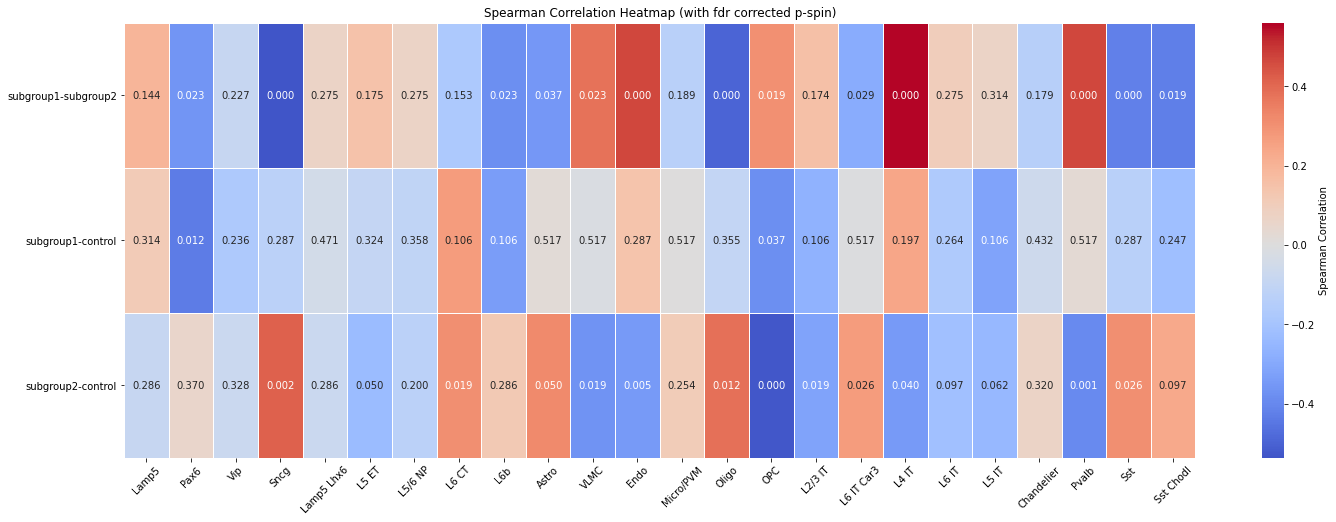

In [42]:
figname = figure_dir+f'/CorticalThickness_Jorstad_Heatmap.pdf'
cell_imag_corr2(CorticalThickness_DK, df_cor, CorticalThickness_pfdr, figname)

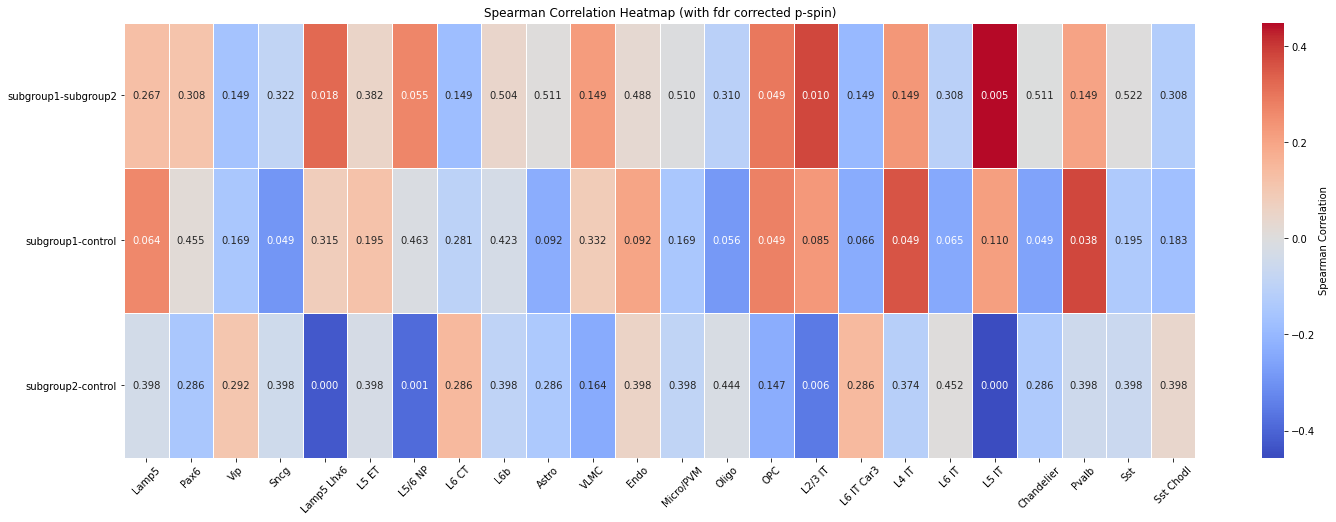

In [43]:
figname = figure_dir+f'/SurfaceArea_Jorstad_Heatmap.pdf'
cell_imag_corr2(SurfaceArea_DK, df_cor, SurfaceArea_pfdr, figname)